In [1]:
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis import *
import matplotlib as mpl
from matplotlib import cm
from scipy import optimize
mpl.rcParams['axes.linewidth'] = 1.4
Z=20
import pandas as pd
from scipy.stats import spearmanr, kendalltau, pearsonr
import math
from matplotlib.ticker import FormatStrFormatter
import random
import seaborn as sns
from scipy.stats import norm, ks_2samp
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score
LOGACT_THRES=1.0
N_ignore = 3

In [2]:
#EXP=Affinity constant, std, ranking
EXP = {"N8A20": [0, 0],
      "N14A20": [0, 0],
      "N9A20" : [0, 0],
      "N6A21" : [0, 0],
      "N1A16" : [0, 0],
      "N1A17" : [0, 0],
      "N3A10" : [0, 0],
      "N3A11" : [0, 0],
      "N3A18" : [0, 0],
      "N6A20" : [120, 5],
      "N15A20": [300, 0],
      "N7A20" : [1100, 0],
      "N16A20": [4.5*10**4, 0],
      "N13A20": [5.0*10**4, 0],
      "N2A11" : [8.5*10**4, 1.5*10**4],
      "N2A10" : [9.3*10**4, 1.2*10**4],
      "N1A9"  : [1.2*10**5, 0.2*10**5],
      "N1A8"  : [1.3*10**5, 0.2*10**5],
      "N1A7"  : [2.6*10**5, 0.6*10**5],
      "N1A13" : [2.7*10**5, 0.3*10**5],
      "N1A1"  : [3.6*10**5, 0],
      "N3A19" : [3.6*10**5, 0.1*10**5],
      "N1A15" : [3.7*10**5, 0],
      "N1A12" : [3.9*10**5, 0.3*10**5],
      "N1A10" : [4.1*10**5, 0.4*10**5],
      "N1A14" : [4.6*10**5, 0],
      "N1A11" : [4.8*10**5, 0.5*10**5],
      "N2A18" : [5.1*10**5, 0.3*10**5],   
      "N1A18" : [6.1*10**5, 1.4*10**5],
      "N2A19" : [1.3*10**6, 0.1*10**6],
      "N1A19" : [2.2*10**6, 0.1*10**6],
      }

Ns = [int(key.split('A')[0].split("N")[1]) for key in EXP.keys()]
As = [int(key.split('A')[1]) for key in EXP.keys()]
Systems = ["N{}A{}".format(n,a) for n,a in zip(Ns, As)]
act_mean = [EXP["N{}A{}".format(n, a)][0] for n, a in zip(Ns, As)]
act_std = [EXP["N{}A{}".format(n, a)][1] for n, a in zip(Ns, As)]
act_rank = np.argsort(-1*np.array(act_mean))

colors = np.round(cm.rainbow(np.linspace(0, 1, len(Ns))), 2)
colnames = ['Nanoparticle', 'Analyte', 'Act_Mean', 'Act_Std', 'Act_Rank', 'Color']
DATA = pd.DataFrame(zip(Ns, As, act_mean, act_std, act_rank, colors), columns=colnames, index=Systems)
DATA.index.name = "System"
print(len(EXP))

31


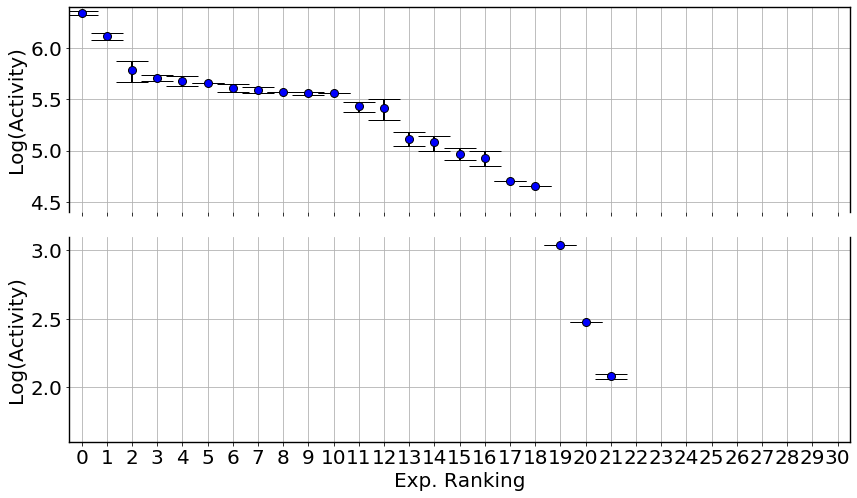

In [3]:
act_means = DATA.Act_Mean.values*1
act_means[act_means==0] = 1.0
act_stds = DATA.Act_Std.values*1
log_means = np.log10(act_means)
DATA['Act_log'] = log_means
err_up = np.log10(act_means+act_stds) - np.log10(act_means)
err_down = np.log10(act_means) - np.log10(act_means-act_stds)
error = np.array([err_down, err_up])
DATA['Act_log_error_up'] = err_up
DATA['Act_log_error_down'] = err_down

subplot_kw={'xlim':(-0.5, max(DATA.Act_Rank)+0.5), 'xticks':np.linspace(0,max(DATA.Act_Rank), max(DATA.Act_Rank)+1)}
fig, axs = plt.subplots(figsize=(14,8), sharex=True, ncols=1, nrows=2, subplot_kw=subplot_kw, gridspec_kw={'hspace':0.12, 'wspace':0.0})
plt.xlabel("Log(Binding constant)", fontsize=Z)
for ax in axs:
    ax.grid()
    ax.set_ylabel("Log(Activity)", fontsize=Z)
    ax.tick_params(labelsize=Z)
    ax.errorbar(DATA.Act_Rank, DATA.Act_log, yerr=error, fmt='o', capsize=16, markeredgecolor='k', markeredgewidth=1, markerfacecolor='b', markersize=8, linewidth=2, color='k')
axs[0].set_ylim(4.4,6.4)
axs[0].spines['bottom'].set_visible(False)
axs[1].set_ylim(1.6,3.1)
axs[1].spines['top'].set_visible(False)
axs[-1].set_xlabel("Exp. Ranking", fontsize=Z)
plt.show()
plt.close()

In [4]:
Act_Rank_Std_up = []
Act_Rank_Std_down = []
N = len(DATA)
n_act = np.sum(DATA.Act_Mean > 0.0)
for i in range(N):
    lower_than = np.sum((DATA.Act_Mean[i] + DATA.Act_Std[i]) >= (DATA.Act_Mean[i:]-DATA.Act_Std[i:]))-1 #-1 to not count itself
    Act_Rank_Std_up.append(lower_than)
    greater_than = np.sum((DATA.Act_Mean[i] - DATA.Act_Std[i]) <= (DATA.Act_Mean[:i]+DATA.Act_Std[:i])) #-1 is absent because of slicing open/closed limits
    Act_Rank_Std_down.append(greater_than)
Act_Rank_Std_up = np.array(Act_Rank_Std_up)
DATA['Act_Rank_Std_up'] = Act_Rank_Std_up*1
DATA['Act_Rank_Std_down'] = Act_Rank_Std_down*1
DATA['Act_Rank_Std_up'].loc[DATA.Act_Mean==0.0] = DATA['Act_Rank_Std_down'].loc[DATA.Act_Mean==0.0]*1
DATA['Act_Rank_Std_down'].loc[DATA.Act_Mean==0.0] = Act_Rank_Std_up[DATA.Act_Mean==0.0]*1
DATA['Active'] = DATA['Act_log'] > LOGACT_THRES
LOGACT_NDX = np.where((DATA['Active'] == False))[0][-1]

DATA = DATA[['Nanoparticle', 'Analyte', 'Act_Mean', 'Act_Std', 'Act_Rank', 'Act_Rank_Std_up', 'Act_Rank_Std_down', 'Act_log', 'Act_log_error_up', 'Act_log_error_down', 'Color', 'Active']]
#print(DATA.head())
#print(DATA.tail())
print(DATA[['Act_Mean', 'Act_Rank', 'Act_Rank_Std_up', 'Act_Rank_Std_down', 'Act_log', 'Act_log_error_up', 'Act_log_error_down', 'Active']])

         Act_Mean  Act_Rank  Act_Rank_Std_up  Act_Rank_Std_down   Act_log  \
System                                                                      
N8A20         0.0        30                0                  8  0.000000   
N14A20        0.0        29                1                  7  0.000000   
N9A20         0.0        28                2                  6  0.000000   
N6A21         0.0        27                3                  5  0.000000   
N1A16         0.0        26                4                  4  0.000000   
N1A17         0.0        25                5                  3  0.000000   
N3A10         0.0        24                6                  2  0.000000   
N3A11         0.0        23                7                  1  0.000000   
N3A18         0.0        22                8                  0  0.000000   
N6A20       120.0        21                0                  0  2.079181   
N15A20      300.0        20                0                  0  2.477121   

C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
def read_text_file(fname):
    f = open(fname, "r")
    fl = f.readlines()
    f.close()
    
    data = []
    for line in fl:
        if "#" not in line and "@" not in line:
            data.append(line.split())
    clean = np.array(data, dtype='float')
    return clean

def ma(data, n_window):
    cumsum, moving_aves = [0], []

    for i, x in enumerate(data, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>n_window:
            moving_ave = (cumsum[i] - cumsum[i-n_window])/n_window
            moving_aves.append(moving_ave)
    moving_aves = np.array(moving_aves)
    return moving_aves

def gaussian(x, mu, sig):
    return np.exp(-0.5*np.power((x - mu)/sig, 2.)) / (sig*(2*np.pi)**0.5)

In [6]:
S = [31, 32, 33]
sasas = []
rogs = []
distances = []
for s in S:
    print("S{}".format(s))
    distace_setup = []
    rog_setup = []
    sasa_setup = []
    for NA in DATA.index:
        print("\t{}".format(NA))
        distance_run = read_text_file("./Mixtures/S{}/DISTS/{}S{}_NVT_dcom.sfu".format(s, NA, s))
        distace_setup.append(distance_run)
        rog_run = read_text_file("./Mixtures/S{}/ROGS/{}S{}_gyr.xvg".format(s, NA, s))
        rog_setup.append(rog_run)
        sasa_run = read_text_file("./Mixtures/S{}/SASA/{}S{}_sasa.xvg".format(s, NA, s))
        sasa_setup.append(sasa_run)
    distances.append(distace_setup)
    rogs.append(rog_setup)
    sasas.append(sasa_setup)
distances = np.array(distances)
sasas = np.array(sasas)[:,:,:,1]*100
rogs = np.array(rogs)[:,:,:,1]*10
times = distances[0,0,:,0]
distances = distances[:,:,:,1:]*10
print(np.shape(times))
print(np.shape(distances))
print(np.shape(rogs))
print(np.shape(sasas))

S31
	N8A20
	N14A20
	N9A20
	N6A21
	N1A16
	N1A17
	N3A10
	N3A11
	N3A18
	N6A20
	N15A20
	N7A20
	N16A20
	N13A20
	N2A11
	N2A10
	N1A9
	N1A8
	N1A7
	N1A13
	N1A1
	N3A19
	N1A15
	N1A12
	N1A10
	N1A14
	N1A11
	N2A18
	N1A18
	N2A19
	N1A19
S32
	N8A20
	N14A20
	N9A20
	N6A21
	N1A16
	N1A17
	N3A10
	N3A11
	N3A18
	N6A20
	N15A20
	N7A20
	N16A20
	N13A20
	N2A11
	N2A10
	N1A9
	N1A8
	N1A7
	N1A13
	N1A1
	N3A19
	N1A15
	N1A12
	N1A10
	N1A14
	N1A11
	N2A18
	N1A18
	N2A19
	N1A19
S33
	N8A20
	N14A20
	N9A20
	N6A21
	N1A16
	N1A17
	N3A10
	N3A11
	N3A18
	N6A20
	N15A20
	N7A20
	N16A20
	N13A20
	N2A11
	N2A10
	N1A9
	N1A8
	N1A7
	N1A13
	N1A1
	N3A19
	N1A15
	N1A12
	N1A10
	N1A14
	N1A11
	N2A18
	N1A18
	N2A19
	N1A19
(2501,)
(3, 31, 2501, 10)
(3, 31, 2501)
(3, 31, 2501)


# Ragius of gyration

In [7]:
t_mask = np.logical_and(times>3, times<4)
rogs_warm = rogs[:,:,t_mask]
DATA['Rog_Mean'] = np.mean(rogs_warm, axis=(0,2))
DATA['Rog_Std'] = np.std(rogs_warm, axis=(0,2))
DATA['Sasa_Mean'] = np.mean(sasas[:,:,t_mask], axis=(0,2))
DATA['Sasa_Std'] = np.std(sasas[:,:,t_mask], axis=(0,2))

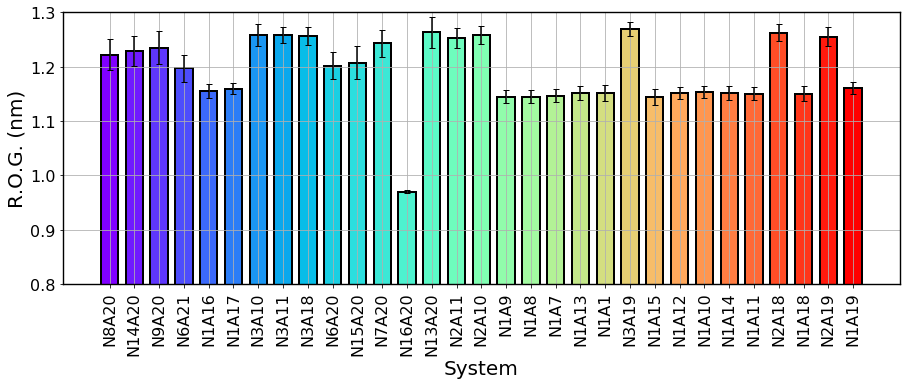

In [8]:
fig, axs = plt.subplots(figsize=(15,5))
axs.tick_params(labelsize=Z-4)
axs.set_xticklabels(DATA.index, rotation=90)
axs.grid()
axs.set_ylim(0.8,1.3)
axs.set_xlabel("System", fontsize=Z)
axs.set_ylabel("R.O.G. (nm)", fontsize=Z)
axs.bar(DATA.index, DATA['Rog_Mean']/10, yerr=DATA['Rog_Std']/10, color=DATA.Color, linewidth=2, ec='k', width=0.7, capsize=3)
plt.show()
plt.close()

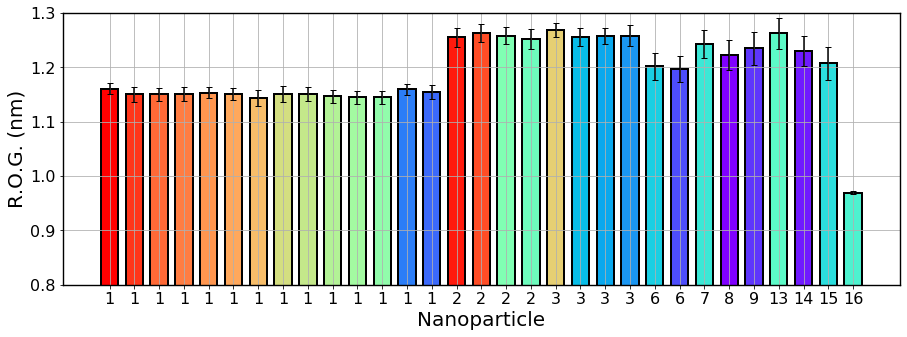

In [9]:
df_sorted = DATA.sort_values(['Nanoparticle', 'Act_Rank'])
fig, axs = plt.subplots(figsize=(15,5))
axs.tick_params(labelsize=Z-4)
axs.set_xticklabels(df_sorted['Nanoparticle'])
axs.grid()
axs.set_ylim(0.8,1.3)
axs.set_xlabel("Nanoparticle", fontsize=Z)
axs.set_ylabel("R.O.G. (nm)", fontsize=Z)
axs.bar(df_sorted.index, df_sorted['Rog_Mean']/10, yerr=df_sorted['Rog_Std']/10, color=df_sorted.Color, linewidth=2, ec='k', width=0.7, capsize=3)
plt.show()
plt.close()

# One replica

In [10]:
def calc_bye_time(eta):
    res = np.ones(np.shape(distances[:,:,0,:]))*times[-1]
    for i in range(len(distances[:,0,0,0])):
        for j in range(len(distances[0,:,0,0])):
            rog = DATA['Rog_Mean'][j]
            for k in range(len(distances[0,0,0,:])):
                try:
                    when = np.where(distances[i,j,:,k] >= eta*rog)[0][0]
                except:
                    when = -1
                res[i,j,k] = times[when]
    res = np.sort(res, axis=2)[:,:,N_ignore:]
    return res

def merge_simulations_bye_time(bye_times):
    times = [bye_times[:,i,:].flatten() for i in range(len(bye_times[0,:,0]))]
    return np.array(times)

In [11]:
Nan = len(distances[0,0,0,:])
NS = len(distances[:,0,0,0])
print(np.shape(calc_bye_time(25)))
print(np.shape(merge_simulations_bye_time(calc_bye_time(2))))

(3, 31, 7)
(31, 21)


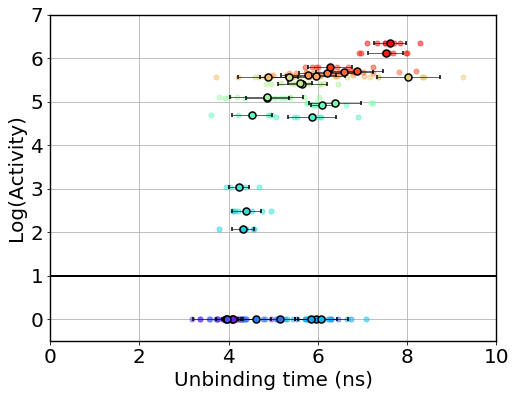

In [12]:
S = 0
ref_eta = 2
bye_times = calc_bye_time(ref_eta)

fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.grid()
ax.axhline(y=LOGACT_THRES, c='k', lw=2, ls='-', zorder=100)
ax.set_xlim(0,10)
ax.set_ylim(-0.5, 7)
ax.set_xlabel("Unbinding time (ns)", fontsize=Z)
ax.set_ylabel("Log(Activity)", fontsize=Z)
ax.tick_params(labelsize=Z)
for act_log, c, bye_time in zip(DATA.Act_log, DATA.Color, bye_times[S]):
    ax.errorbar(bye_time, [act_log]*(Nan-N_ignore), c=c, fmt='o', ms=5, alpha=0.5)
    ax.errorbar(np.mean(bye_time), act_log, xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.6, ecolor='k', capsize=2)
plt.savefig("Sensspec_SingleMDeta/Act-time.png", format='png', dpi=300)
plt.show()
plt.close()

# 3 replicas

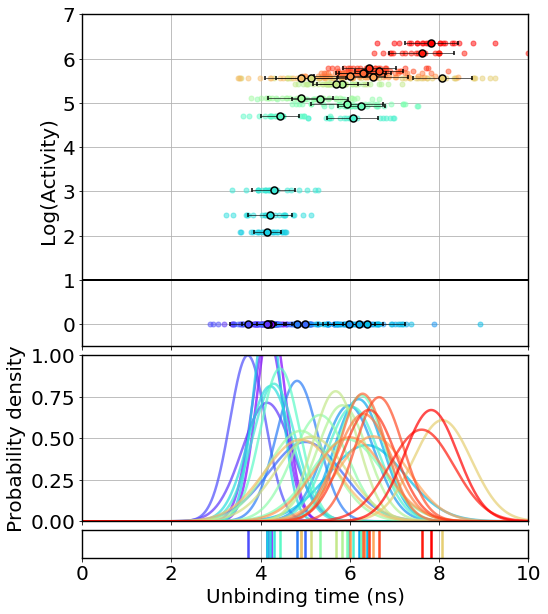

In [13]:
merged_bye_times = merge_simulations_bye_time(bye_times)

fig, axs = plt.subplots(figsize=(8,10), sharex=True, ncols=1, nrows=3, gridspec_kw={'hspace':0.05, 'height_ratios': [3, 1.5, 0.25]})
for ax in axs:
    ax.grid()
    ax.set_xlim(0,10)
    ax.tick_params(labelsize=Z)

axs[0].axhline(y=LOGACT_THRES, c='k', lw=2, ls='-', zorder=100)
axs[0].set_ylim(-0.5, 7)
axs[1].set_ylim(0,1.)
axs[2].set_xlabel("Unbinding time (ns)", fontsize=Z)
axs[0].set_ylabel("Log(Activity)", fontsize=Z)
axs[1].set_ylabel("Probability density", fontsize=Z)
axs[2].set_yticks([])
for act_log, c, bye_time in zip(DATA.Act_log, DATA.Color, merged_bye_times):
    axs[0].errorbar(bye_time, [act_log]*(Nan-N_ignore)*NS, c=c, fmt='o', ms=5, alpha=0.5)
    axs[0].errorbar(np.mean(bye_time), act_log, xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.6, ecolor='k', capsize=2)
    mu, sigma = norm.fit(bye_time)
    axs[1].plot(times, gaussian(times, mu, sigma), color=c, alpha=0.7, lw=2.5)
    axs[2].axvline(x=np.mean(bye_time), ymin=0, ymax=1, color=c, lw=2.5)
plt.savefig("Sensspec_SingleMDeta/Act-timedistr.png", format='png', dpi=300)
plt.show()
plt.close()

In [14]:
def confusion_matrix_sfu(merged_bye_times, time_thres):
    mean_bye_times = np.mean(merged_bye_times, axis=1)
    pred_active = (mean_bye_times > time_thres).astype('float')
    active = DATA.Active.astype('float')
    TP = np.sum(pred_active+active==2)
    TN = np.sum(pred_active+active==0)
    FP = np.sum(pred_active-active==1)
    FN = np.sum(pred_active-active==-1)
    return TP, TN, FP, FN

In [15]:
ref_etas = np.linspace(1, 4, 100)
time_thresholds = np.linspace(0, 10, 300)
accuracy, sensitivity, specificity = [], [], []
for ref_eta in ref_etas:
    bye_times = calc_bye_time(ref_eta)
    merged_bye_times = merge_simulations_bye_time(bye_times)
    acc, sens, spec = [], [], []
    for time_thres in time_thresholds:
        tp, tn, fp, fn = confusion_matrix_sfu(merged_bye_times, time_thres)
        acc.append((tp+tn)/(tp+tn+fp+fn))
        sens.append(tp/(tp+fn))
        spec.append(tn/(tn+fp))
    accuracy.append(acc)
    sensitivity.append(sens)
    specificity.append(spec)
accuracy = np.array(accuracy)
sensitivity = np.array(sensitivity)
specificity = np.array(specificity)

In [16]:
#opt_array and decide_array could be interchanged for different, interesting results
print(np.shape(accuracy))
blo = -1
opt_array = (sensitivity+specificity)*1 #Array to which get the best values from
decide_array = 0.5*accuracy #Array to decide which indistinguishable indices to keep
ndx_etas, ndx_times = np.where(opt_array==np.sort(opt_array.flatten())[blo])
decide_max = np.max(decide_array[ndx_etas, ndx_times])
tmp_ndxs = np.where(decide_array==decide_max)
best_eta_ndx = [i for i, j in zip(ndx_etas, ndx_times) if i in tmp_ndxs[0] and j in tmp_ndxs[1]]
best_time_thres_ndx = [j for i, j in zip(ndx_etas, ndx_times) if i in tmp_ndxs[0] and j in tmp_ndxs[1]]
print(best_eta_ndx, best_time_thres_ndx)

(100, 300)
[36, 36, 43, 43, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 

In [17]:
blp = 0
best_eta_ndx = best_eta_ndx[blp]
best_time_thres_ndx = best_time_thres_ndx[blp]

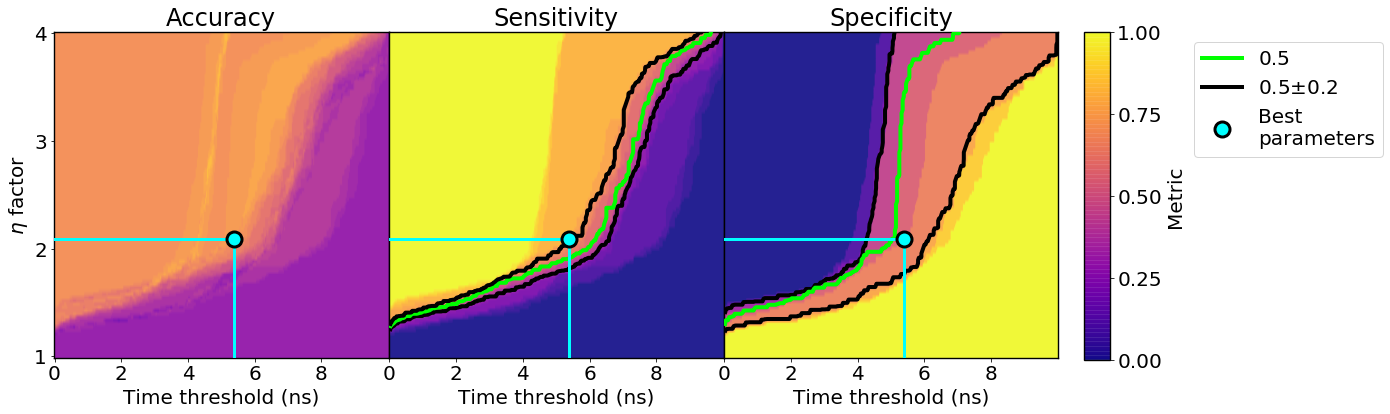

In [18]:
cmap='plasma'
titles = ['Accuracy', 'Sensitivity', 'Specificity']
maps = [accuracy, sensitivity, specificity]

best_eta = ref_etas[best_eta_ndx]
best_time_thres = time_thresholds[best_time_thres_ndx]

fig, axs = plt.subplots(figsize=(18, 6), ncols=3, nrows=1, gridspec_kw={'wspace':0.0})
for i, (ax, title, mapa) in enumerate(zip(axs, titles, maps)):
    ax.axhline(y=best_eta_ndx, xmin=0, xmax=best_time_thres_ndx/len(accuracy[0]), c=(0,1,1), lw=3, zorder=15)
    ax.axvline(x=best_time_thres_ndx, ymin=0, ymax=best_eta_ndx/len(accuracy), c=(0,1,1), lw=3, zorder=15)
    ax.errorbar(best_time_thres_ndx, best_eta_ndx, fmt='o', ms=15, mec='k', mew=3, color=(0,1,1), zorder=20, label="Best\nparameters")
    cax = ax.imshow(mapa, origin='lower', aspect='auto', vmin=0, vmax=1, interpolation='bilinear', cmap=cmap, alpha=0.9)
    if i != 0:
        ax.contour(mapa, levels=np.array([0.3,0.5,0.7]), colors=['k',(0,1,0),'k'], linewidths=[4], linestyles='-', zorder=10, origin='lower')
    ax.set_title(title, fontsize=Z+4)
    ax.set_yticks([])
    ax.set_xticks(np.linspace(0, len(accuracy[0,:])-1, 6)[:-1])
    ax.set_xticklabels(np.linspace(0, 10, 6, dtype='int'))
    ax.tick_params(labelsize=Z)
    ax.set_xlabel("Time threshold (ns)", fontsize=Z)
axs[0].set_yticks(np.linspace(0, len(accuracy)-1, 4))
axs[0].set_yticklabels(np.linspace(1, 4, 4, dtype='int'))
axs[0].set_ylabel(r"$\eta$ factor", fontsize=Z)
axs[2].plot([],[], lw=4, c=(0,1,0), label="0.5")
axs[2].plot([],[], lw=4, c='k', label=r"0.5$\pm$0.2")
axs[2].legend(fontsize=Z, bbox_to_anchor=(1.5,0.5,0.5,0.5))
a = plt.axes([0.92,0.12,0.02,0.76])
cbar = fig.colorbar(cax, ax=a, cax=a, ticks=np.linspace(0,1,5))
cbar.ax.tick_params(labelsize=Z)
cbar.ax.set_ylabel("Metric", fontsize=Z)
plt.savefig("Sensspec_SingleMDeta/Metrics.png", format='png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [19]:
print("Best time threshold: {:.2f} ns ({:.0f} K)".format(best_time_thres, best_time_thres*100))
print("Best eta factor: {:.2f}".format(best_eta))
print("Accuracy at best point: {:.2f}".format(accuracy[best_eta_ndx, best_time_thres_ndx]))
print("Sensitivity at best point: {:.2f}".format(sensitivity[best_eta_ndx, best_time_thres_ndx]))
print("Specificity at best point: {:.2f}".format(specificity[best_eta_ndx, best_time_thres_ndx]))

Best time threshold: 5.38 ns (538 K)
Best eta factor: 2.09
Accuracy at best point: 0.77
Sensitivity at best point: 0.82
Specificity at best point: 0.67


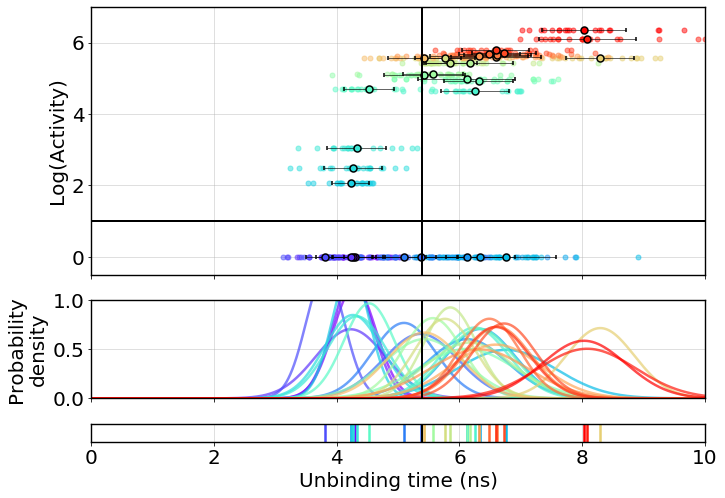

In [20]:
bye_times = calc_bye_time(best_eta)
merged_bye_times = merge_simulations_bye_time(bye_times)

fig, axs = plt.subplots(figsize=(11,8), sharex=True, ncols=1, nrows=3, gridspec_kw={'hspace':0.2, 'height_ratios': [3, 1.1, 0.2]})
for ax in axs:
    ax.axvline(x=best_time_thres, ymin=0, ymax=1, c='k', lw=2, ls='-', zorder=100)
    ax.grid(alpha=0.5)
    ax.set_xlim(0,10)
    ax.tick_params(labelsize=Z)

axs[0].axhline(y=LOGACT_THRES, c='k', lw=2, ls='-', zorder=100)
axs[0].set_ylim(-0.5, 7)
axs[1].set_ylim(0,1)
axs[2].set_xlabel("Unbinding time (ns)", fontsize=Z)
axs[0].set_ylabel("Log(Activity)", fontsize=Z)
axs[1].set_ylabel("Probability\ndensity", fontsize=Z)
axs[1].set_yticks([0,0.5,1])
axs[2].set_yticks([])
for act_log, c, bye_time in zip(DATA.Act_log, DATA.Color, merged_bye_times):
    axs[0].errorbar(bye_time, [act_log]*(Nan-N_ignore)*NS, c=c, fmt='o', ms=5, alpha=0.5)
    axs[0].errorbar(np.mean(bye_time), act_log, xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.6, ecolor='k', capsize=2)
    mu, sigma = norm.fit(bye_time)
    axs[1].plot(times, gaussian(times, mu, sigma), color=c, alpha=0.7, lw=2.5)
    axs[2].axvline(x=np.mean(bye_time), ymin=0, ymax=1, color=c, lw=2.5)
#axs[0].text(0.2, LOGACT_THRES+0.2, s="False\npositives", fontsize=Z-4)
#axs[0].text(0.2, LOGACT_THRES-0.8, s="True\nnegatives", fontsize=Z-4)
#axs[0].text(9.8, LOGACT_THRES+0.2, s="True\npositives", fontsize=Z-4, horizontalalignment='right')
#axs[0].text(9.8, LOGACT_THRES-0.8, s="False\nnegatives", fontsize=Z-4, horizontalalignment='right')
plt.savefig("Sensspec_SingleMDeta/Act-timedistr_thres.png", format='png', dpi=300)
plt.show()
plt.close()

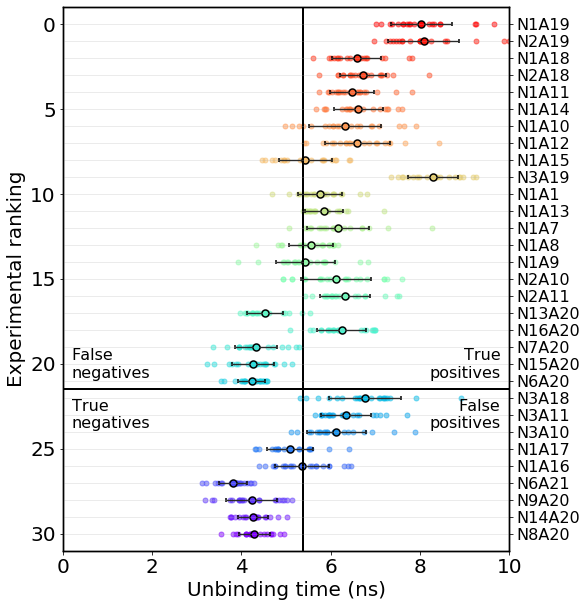

In [21]:
fig = plt.figure(figsize=(8,10))
ax = plt.axes()
ax2 = ax.twinx()
ax.set_ylim(31,-1)
ax2.set_ylim(31,-1)
ax2.set_yticks(DATA.Act_Rank)
ax2.set_yticklabels(DATA.index, fontsize=Z-4)
ax2.set_xticks([])
ax2.grid(alpha=0.3)
ax.set_xlim(0,10)
ax.set_xticks(np.linspace(0,10,6))
ax.tick_params(labelsize=Z)
ax.set_xlabel("Unbinding time (ns)", fontsize=Z)
ax.set_ylabel("Experimental ranking", fontsize=Z)
ax.axvline(x=best_time_thres, ymin=0, ymax=1, c='k', lw=2, ls='-', zorder=100)
ax.axhline(y=DATA.Act_Rank[np.where(DATA.Active==False)[0][-1]]-0.5, c='k', lw=2, ls='-', zorder=100)
for i, (bye_time, rank, c) in enumerate(zip(merged_bye_times, DATA.Act_Rank, DATA.Color)):
    ax.errorbar([bye_time], [rank], c=c, fmt='o', ms=5, alpha=0.5)
    ax.errorbar(np.mean(bye_time), [rank], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=1.3, ecolor='k', capsize=2)
ax.text(0.2, N-LOGACT_NDX+0.8,s="True\nnegatives", fontsize=Z-4)
ax.text(9.8, N-LOGACT_NDX+0.8,s="False\npositives", fontsize=Z-4, horizontalalignment='right')
ax.text(0.2, N-LOGACT_NDX-2.2,s="False\nnegatives", fontsize=Z-4)
ax.text(9.8, N-LOGACT_NDX-2.2,s="True\npositives", fontsize=Z-4, horizontalalignment='right')
plt.savefig("Sensspec_SingleMDeta/Rank-time_thres.png", format='png', dpi=300)
plt.show()
plt.close()

# True positives

In [22]:
DATA.loc[(DATA.Active+(np.mean(merged_bye_times, axis=1)>best_time_thres).astype('int'))==2]

,Nanoparticle,Analyte,Act_Mean,Act_Std,Act_Rank,Act_Rank_Std_up,Act_Rank_Std_down,Act_log,Act_log_error_up,Act_log_error_down,Color,Active,Rog_Mean,Rog_Std,Sasa_Mean,Sasa_Std
System,,,,,,,,,,,,,,,,
N16A20,16,20,45000.0,0.0,18,0,0,4.653213,0.000000,0.000000,"[0.3, 0.95, 0.81, 1.0]",True,9.697656,0.031576,10499.859705,322.785951
N2A11,2,11,85000.0,15000.0,16,2,0,4.929419,0.070581,0.084321,"[0.43, 0.99, 0.74, 1.0]",True,12.528823,0.183369,13036.503748,599.999914
N2A10,2,10,93000.0,12000.0,15,1,1,4.968483,0.052706,0.059998,"[0.5, 1.0, 0.7, 1.0]",True,12.581663,0.157628,13181.559973,502.548338
N1A9,1,9,120000.0,20000.0,14,1,2,5.079181,0.066947,0.079181,"[0.57, 0.99, 0.67, 1.0]",True,11.448596,0.124154,11177.138019,439.340066
N1A8,1,8,130000.0,20000.0,13,0,1,5.113943,0.062148,0.072551,"[0.64, 0.98, 0.63, 1.0]",True,11.446607,0.123492,11060.273896,354.575781
N1A7,1,7,260000.0,60000.0,12,1,0,5.414973,0.090177,0.113943,"[0.7, 0.95, 0.59, 1.0]",True,11.464483,0.117257,11512.184873,323.502897
N1A13,1,13,270000.0,30000.0,11,0,1,5.431364,0.045757,0.051153,"[0.77, 0.91, 0.54, 1.0]",True,11.511791,0.127649,11125.133735,423.221826
N1A1,1,1,360000.0,0.0,10,2,0,5.556303,0.000000,0.000000,"[0.83, 0.87, 0.5, 1.0]",True,11.507761,0.148818,11293.094511,402.180167
N3A19,3,19,360000.0,10000.0,9,3,1,5.556303,0.011899,0.012234,"[0.9, 0.81, 0.45, 1.0]",True,12.687815,0.124762,13660.478849,642.285596


# False positives

In [23]:
DATA.loc[(DATA.Active-(np.mean(merged_bye_times, axis=1)>best_time_thres).astype('int'))==-1]

,Nanoparticle,Analyte,Act_Mean,Act_Std,Act_Rank,Act_Rank_Std_up,Act_Rank_Std_down,Act_log,Act_log_error_up,Act_log_error_down,Color,Active,Rog_Mean,Rog_Std,Sasa_Mean,Sasa_Std
System,,,,,,,,,,,,,,,,
N3A10,3,10,0.0,0.0,24,6,2,0.0,0.0,0.0,"[0.1, 0.59, 0.95, 1.0]",False,12.581886,0.193992,12956.388621,754.666892
N3A11,3,11,0.0,0.0,23,7,1,0.0,0.0,0.0,"[0.04, 0.66, 0.93, 1.0]",False,12.579910,0.146357,13177.691299,600.966932
N3A18,3,18,0.0,0.0,22,8,0,0.0,0.0,0.0,"[0.03, 0.74, 0.91, 1.0]",False,12.559191,0.165859,13147.861178,662.865300


# False negatives

In [24]:
DATA.loc[(DATA.Active-(np.mean(merged_bye_times, axis=1)>best_time_thres).astype('int'))==1]

,Nanoparticle,Analyte,Act_Mean,Act_Std,Act_Rank,Act_Rank_Std_up,Act_Rank_Std_down,Act_log,Act_log_error_up,Act_log_error_down,Color,Active,Rog_Mean,Rog_Std,Sasa_Mean,Sasa_Std
System,,,,,,,,,,,,,,,,
N6A20,6,20,120.0,5.0,21,0,0,2.079181,0.017729,0.018483,"[0.1, 0.81, 0.89, 1.0]",True,12.015950,0.244552,11625.866667,1287.045334
N15A20,15,20,300.0,0.0,20,0,0,2.477121,0.000000,0.000000,"[0.17, 0.87, 0.87, 1.0]",True,12.073602,0.298037,11823.766399,1471.197256
N7A20,7,20,1100.0,0.0,19,0,0,3.041393,0.000000,0.000000,"[0.23, 0.91, 0.84, 1.0]",True,12.427655,0.254725,12729.544043,1457.423260
N13A20,13,20,50000.0,0.0,17,0,0,4.698970,0.000000,0.000000,"[0.36, 0.98, 0.78, 1.0]",True,12.627795,0.281741,12439.599866,1425.729288


# True negatives

In [25]:
DATA.loc[(DATA.Active+(np.mean(merged_bye_times, axis=1)>best_time_thres).astype('int'))==0]

,Nanoparticle,Analyte,Act_Mean,Act_Std,Act_Rank,Act_Rank_Std_up,Act_Rank_Std_down,Act_log,Act_log_error_up,Act_log_error_down,Color,Active,Rog_Mean,Rog_Std,Sasa_Mean,Sasa_Std
System,,,,,,,,,,,,,,,,
N8A20,8,20,0.0,0.0,30,0,8,0.0,0.0,0.0,"[0.5, 0.0, 1.0, 1.0]",False,12.222698,0.278393,11760.771084,1579.543609
N14A20,14,20,0.0,0.0,29,1,7,0.0,0.0,0.0,"[0.44, 0.1, 1.0, 1.0]",False,12.293464,0.274507,12253.439625,1451.030026
N9A20,9,20,0.0,0.0,28,2,6,0.0,0.0,0.0,"[0.37, 0.21, 0.99, 1.0]",False,12.348903,0.299096,13136.572691,1700.491001
N6A21,6,21,0.0,0.0,27,3,5,0.0,0.0,0.0,"[0.3, 0.3, 0.99, 1.0]",False,11.968188,0.245952,11318.383668,1411.111687
N1A16,1,16,0.0,0.0,26,4,4,0.0,0.0,0.0,"[0.23, 0.41, 0.98, 1.0]",False,11.543482,0.128431,11198.530120,391.572558
N1A17,1,17,0.0,0.0,25,5,3,0.0,0.0,0.0,"[0.17, 0.49, 0.97, 1.0]",False,11.597224,0.105052,11335.532530,415.699600


# Nanoparticles

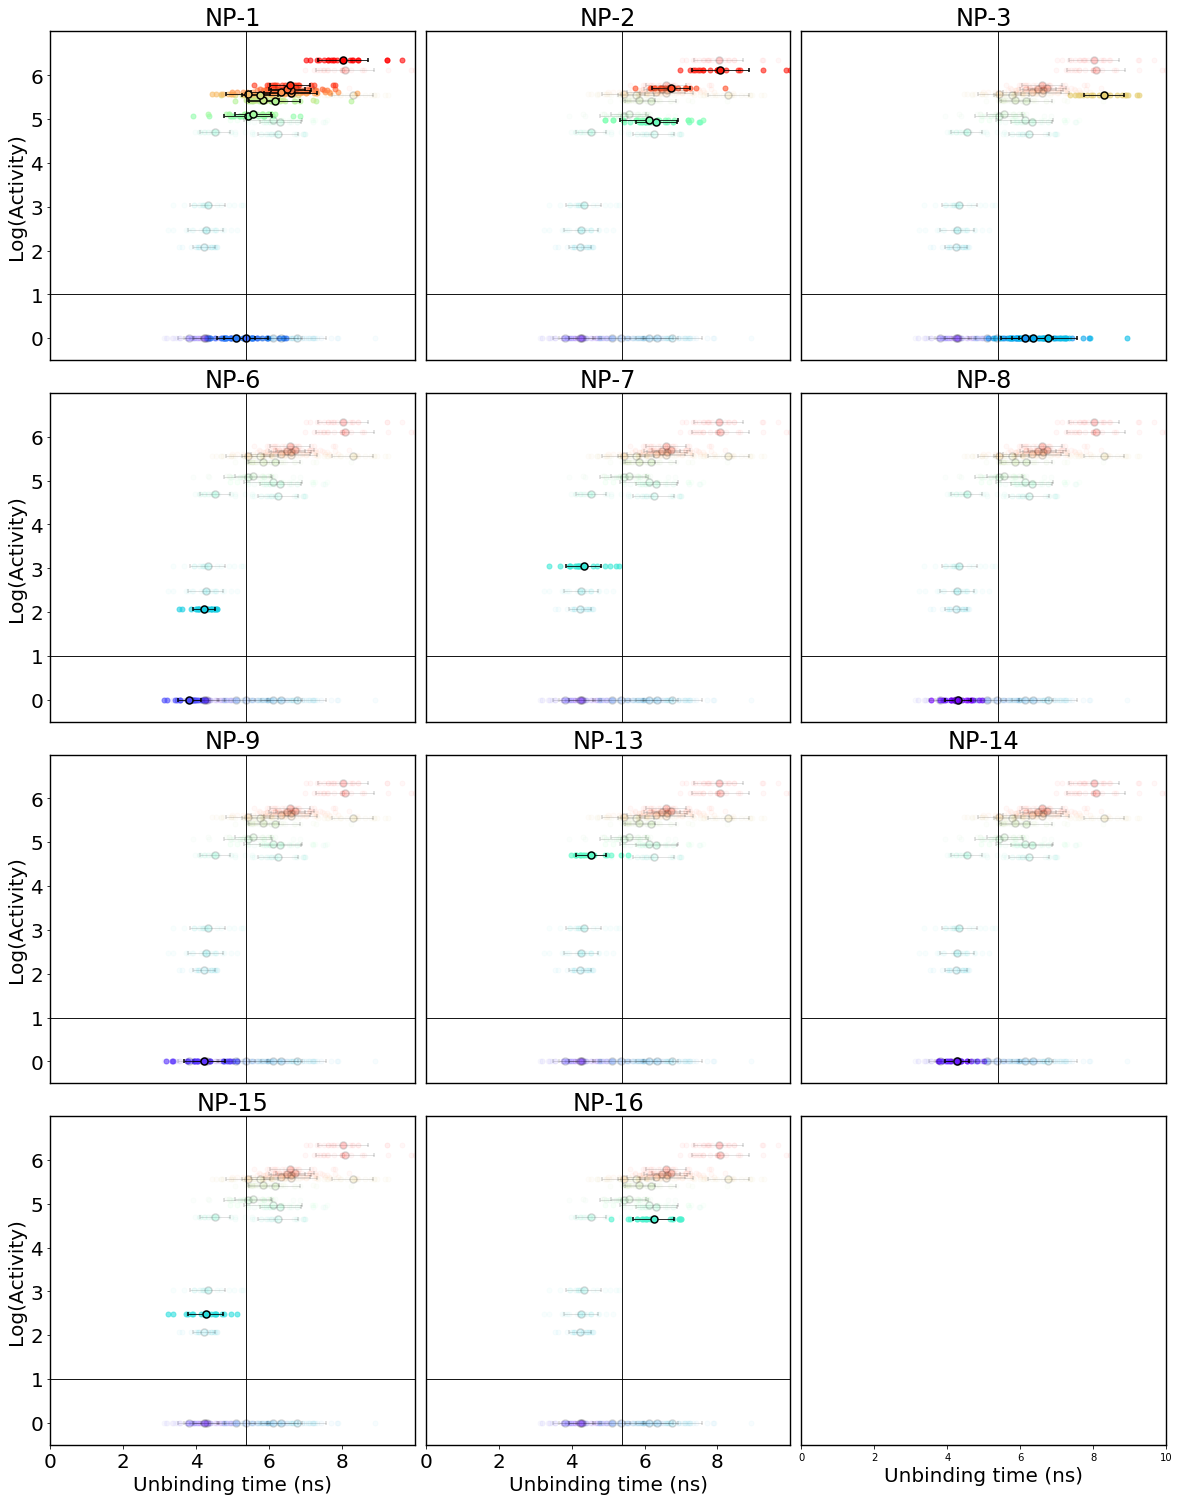

In [26]:
fig, axs = plt.subplots(figsize=(20, 26), ncols=3, nrows=4, gridspec_kw={'hspace':0.1, 'wspace':0.03})
for a, (ax, NN) in enumerate(zip(axs.flatten(), np.unique(DATA.Nanoparticle))):
    ax.set_ylim(-0.5, 7)
    ax.set_title("NP-{}".format(NN), fontsize=Z+4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axhline(y=LOGACT_THRES, xmin=0, xmax=1, c='k', lw=0.9, ls='-', zorder=100)
    ax.axvline(x=best_time_thres, ymin=0, ymax=1, c='k', lw=0.9, ls='-', zorder=100)
    ax.tick_params(labelsize=Z)
    ax.set_xlim(0,10)
    for i, (bye_time, act_log, c, nn) in enumerate(zip(merged_bye_times, DATA.Act_log, DATA.Color, DATA.Nanoparticle)):
        if nn == NN:
            al1 = 0.6
            al2 = 1.0
        else:
            al1 = 0.03
            al2 = 0.15
        ax.errorbar([bye_time], [act_log], c=c, fmt='o', ms=5, alpha=al1)
        ax.errorbar(np.mean(bye_time), [act_log], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
for ax in axs[:,0]:
    ax.set_yticks(np.linspace(0,6,7))
    ax.set_ylabel("Log(Activity)", fontsize=Z)
for a, ax in enumerate(axs[-1,:]):
    if a%3==2:
        ax.set_xticks(np.linspace(0, 10, 6))
    else:
        ax.set_xticks(np.arange(0,8.1,2))
    ax.set_xlabel("Unbinding time (ns)", fontsize=Z)

axs[-1,-1].set_yticks([])
plt.savefig("Sensspec_SingleMDeta/NP_dependence.png", format='png', dpi=300)
plt.show()
plt.close()

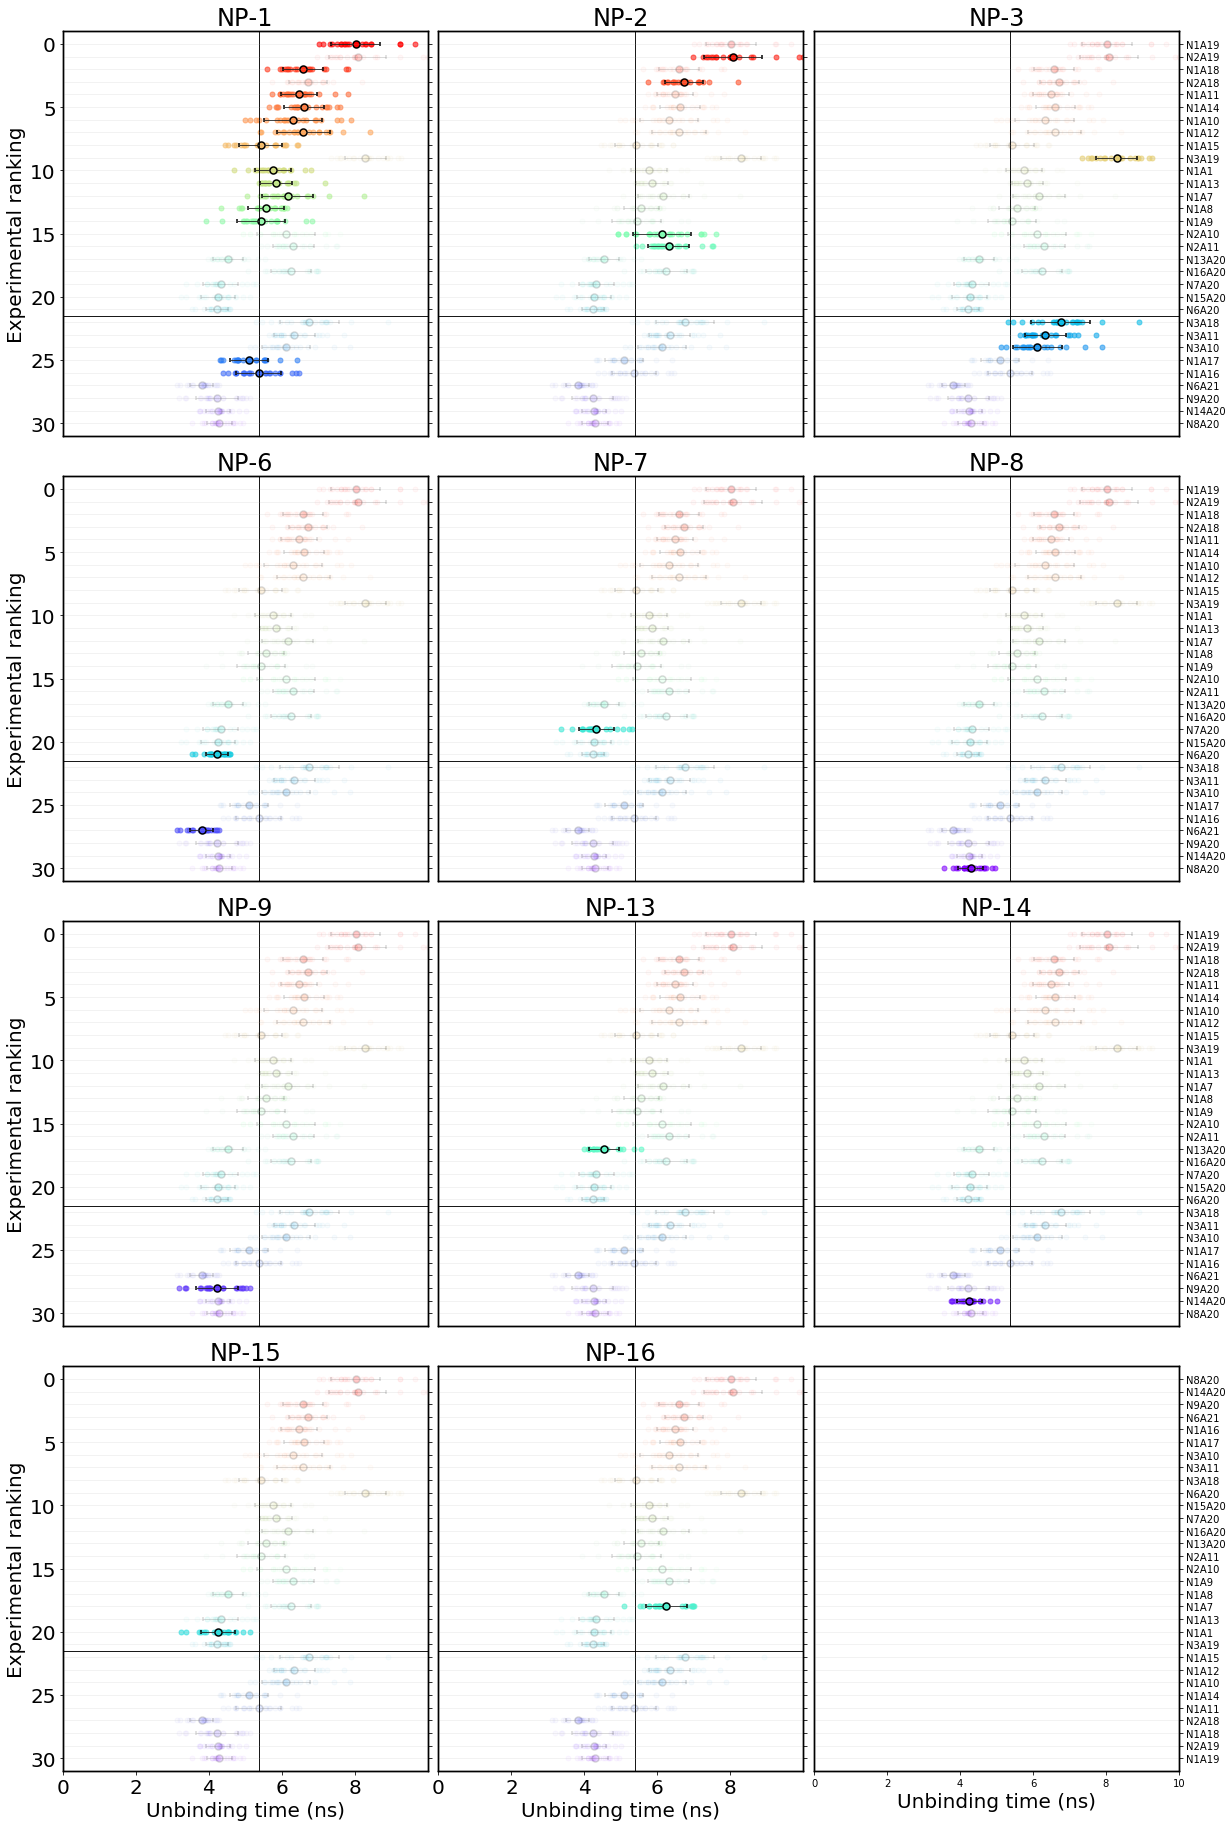

In [27]:
fig, axs = plt.subplots(figsize=(20, 32), ncols=3, nrows=4, gridspec_kw={'hspace':0.1, 'wspace':0.03})
for a, (ax, NN) in enumerate(zip(axs.flatten(), np.unique(DATA.Nanoparticle))):
    ax2 = ax.twinx()
    ax2.set_ylim(31,-1)
    ax2.set_yticks(DATA.Act_Rank)
    ax2.grid(alpha=0.2)
    if a%3==2:
        ax2.set_yticklabels(DATA.index)
    else:
        ax2.set_yticklabels([])
    ax.set_ylim(31,-1)
    ax.set_title("NP-{}".format(NN), fontsize=Z+4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axvline(x=best_time_thres, ymin=0, ymax=1, c='k', lw=0.9, ls='-', zorder=100)
    ax.axhline(y=DATA.Act_Rank[np.where(DATA.Active==False)[0][-1]]-0.5, c='k', lw=0.9, ls='-', zorder=100)
    ax.tick_params(labelsize=Z)
    ax.set_xlim(0,10)
    for i, (bye_time, rank, c, nn) in enumerate(zip(merged_bye_times, DATA.Act_Rank, DATA.Color, DATA.Nanoparticle)):
        if nn == NN:
            al1 = 0.6
            al2 = 1.0
        else:
            al1 = 0.03
            al2 = 0.15
        ax.errorbar([bye_time], [rank], c=c, fmt='o', ms=5, alpha=al1)
        ax.errorbar(np.mean(bye_time), [rank], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
for ax in axs[:,0]:
    ax.set_yticks(np.linspace(0,30,7))
    ax.set_ylabel("Experimental ranking", fontsize=Z)
for a, ax in enumerate(axs[-1,:]):
    if a%3==2:
        ax.set_xticks(np.linspace(0, 10, 6))
    else:
        ax.set_xticks(np.arange(0,8.1,2))
    ax.set_xlabel("Unbinding time (ns)", fontsize=Z)

axs[-1,-1].set_yticks([])
ax2 = axs[-1,-1].twinx()
ax2.set_ylim(-1,31)
ax2.set_yticks(DATA.Act_Rank)
ax2.grid(alpha=0.2)
ax2.set_yticklabels(DATA.index)
plt.savefig("Sensspec_SingleMDeta/NP_dependence_rank.png", format='png', dpi=300)
plt.show()
plt.close()

# Analytes

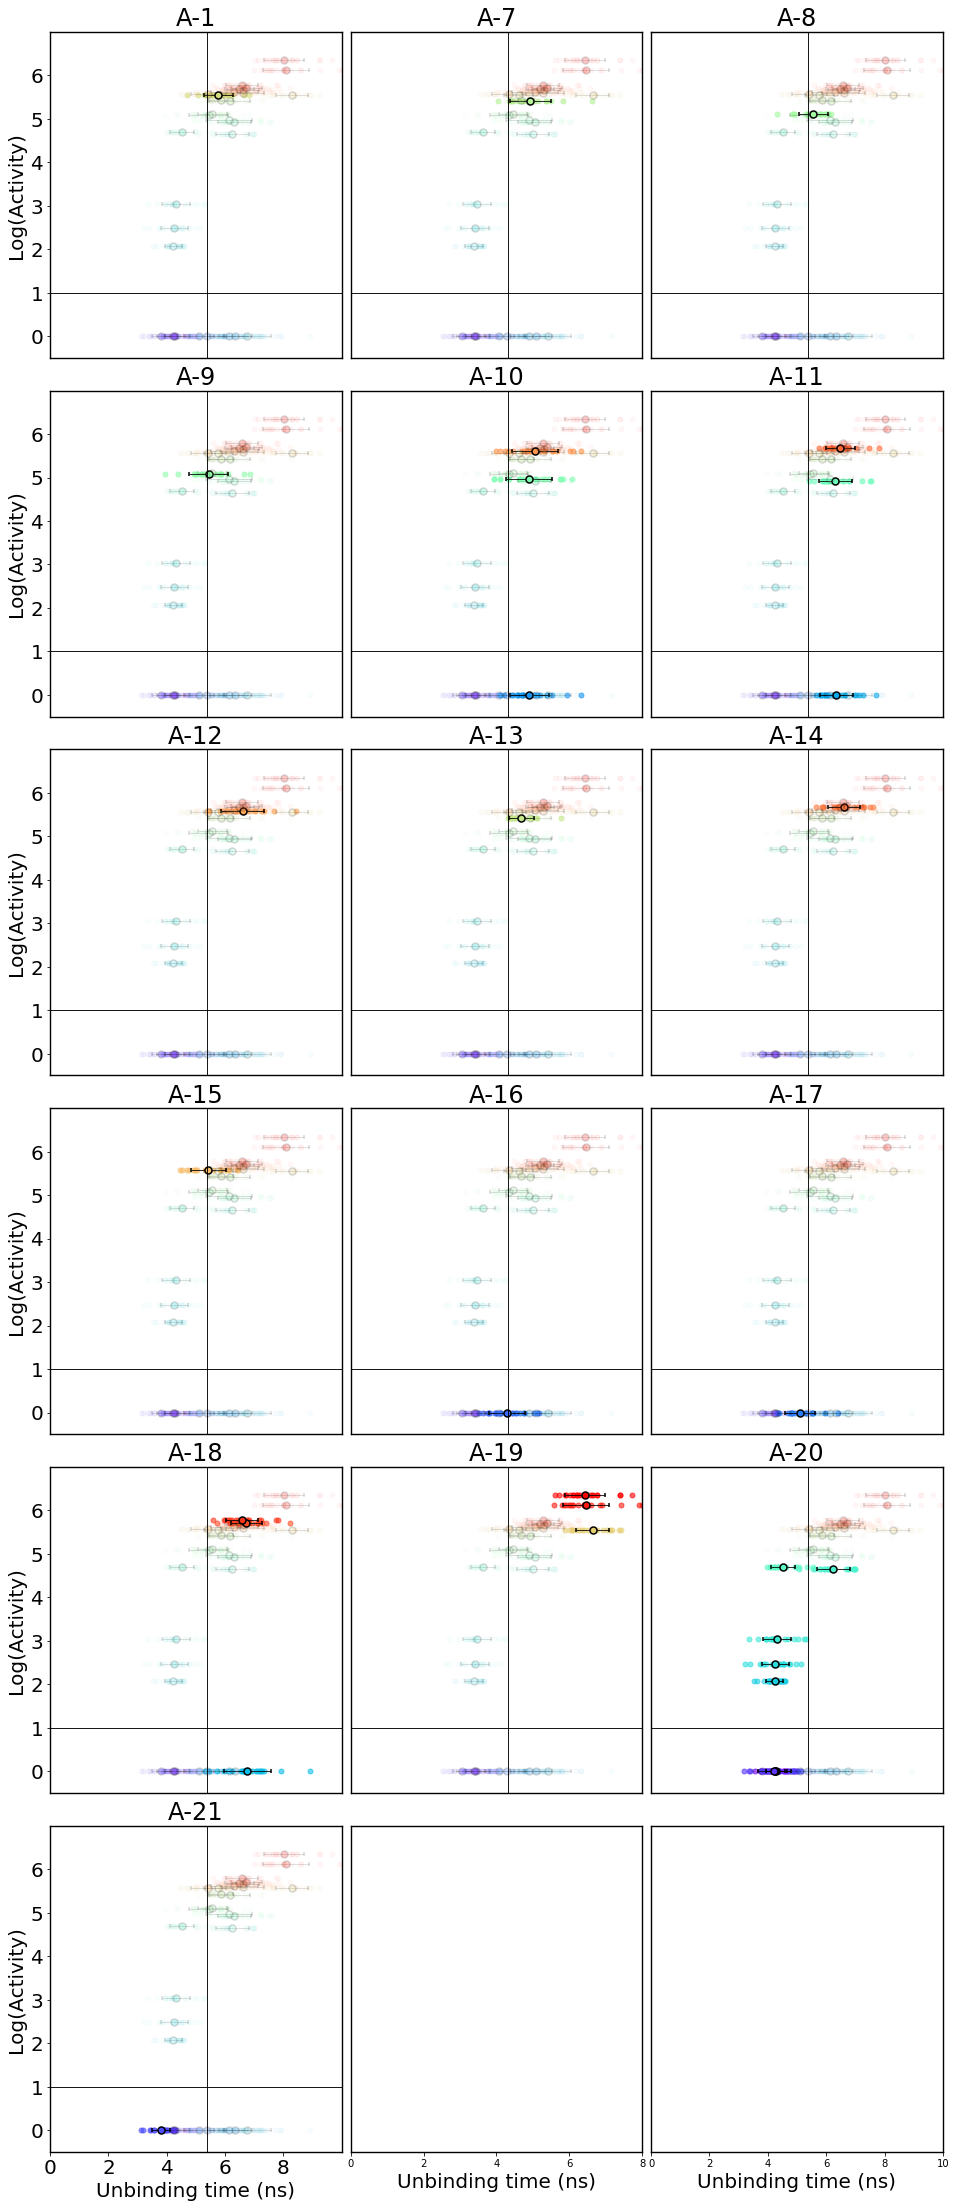

In [28]:
fig, axs = plt.subplots(figsize=(16, 39), ncols=3, nrows=6, gridspec_kw={'hspace':0.1, 'wspace':0.03})
for a, (ax, AA) in enumerate(zip(axs.flatten(), np.unique(DATA.Analyte))):
    ax.set_ylim(-0.5,7)
    ax.set_title("A-{}".format(AA), fontsize=Z+4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axhline(y=LOGACT_THRES, xmin=0, xmax=1, c='k', lw=0.9, ls='-', zorder=100)
    ax.axvline(x=best_time_thres, ymin=0, ymax=1, c='k', lw=0.9, ls='-', zorder=100)
    ax.tick_params(labelsize=Z)
    ax.set_xlim(0,10)
    for i, (bye_time, act_log, c, aa) in enumerate(zip(merged_bye_times, DATA.Act_log, DATA.Color, DATA.Analyte)):
        if aa == AA:
            al1 = 0.6
            al2 = 1.0
        else:
            al1 = 0.03
            al2 = 0.15
        ax.errorbar([bye_time], [act_log], c=c, fmt='o', ms=5, alpha=al1)
        ax.errorbar(np.mean(bye_time), [act_log], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
for ax in axs[:,0]:
    ax.set_yticks(np.linspace(0,6,7))
    ax.set_ylabel("Log(Activity)", fontsize=Z)
for a, ax in enumerate(axs[-1,:]):
    if a%3==2:
        ax.set_xticks(np.linspace(0, 10, 6))
    else:
        ax.set_xticks(np.arange(0,8.1,2))
    ax.set_xlabel("Unbinding time (ns)", fontsize=Z)
    
axs[-1,-2].set_yticks([])
axs[-1,-1].set_yticks([])
plt.savefig("Sensspec_SingleMDeta/A_dependence.png", format='png', dpi=300)
plt.show()
plt.close()

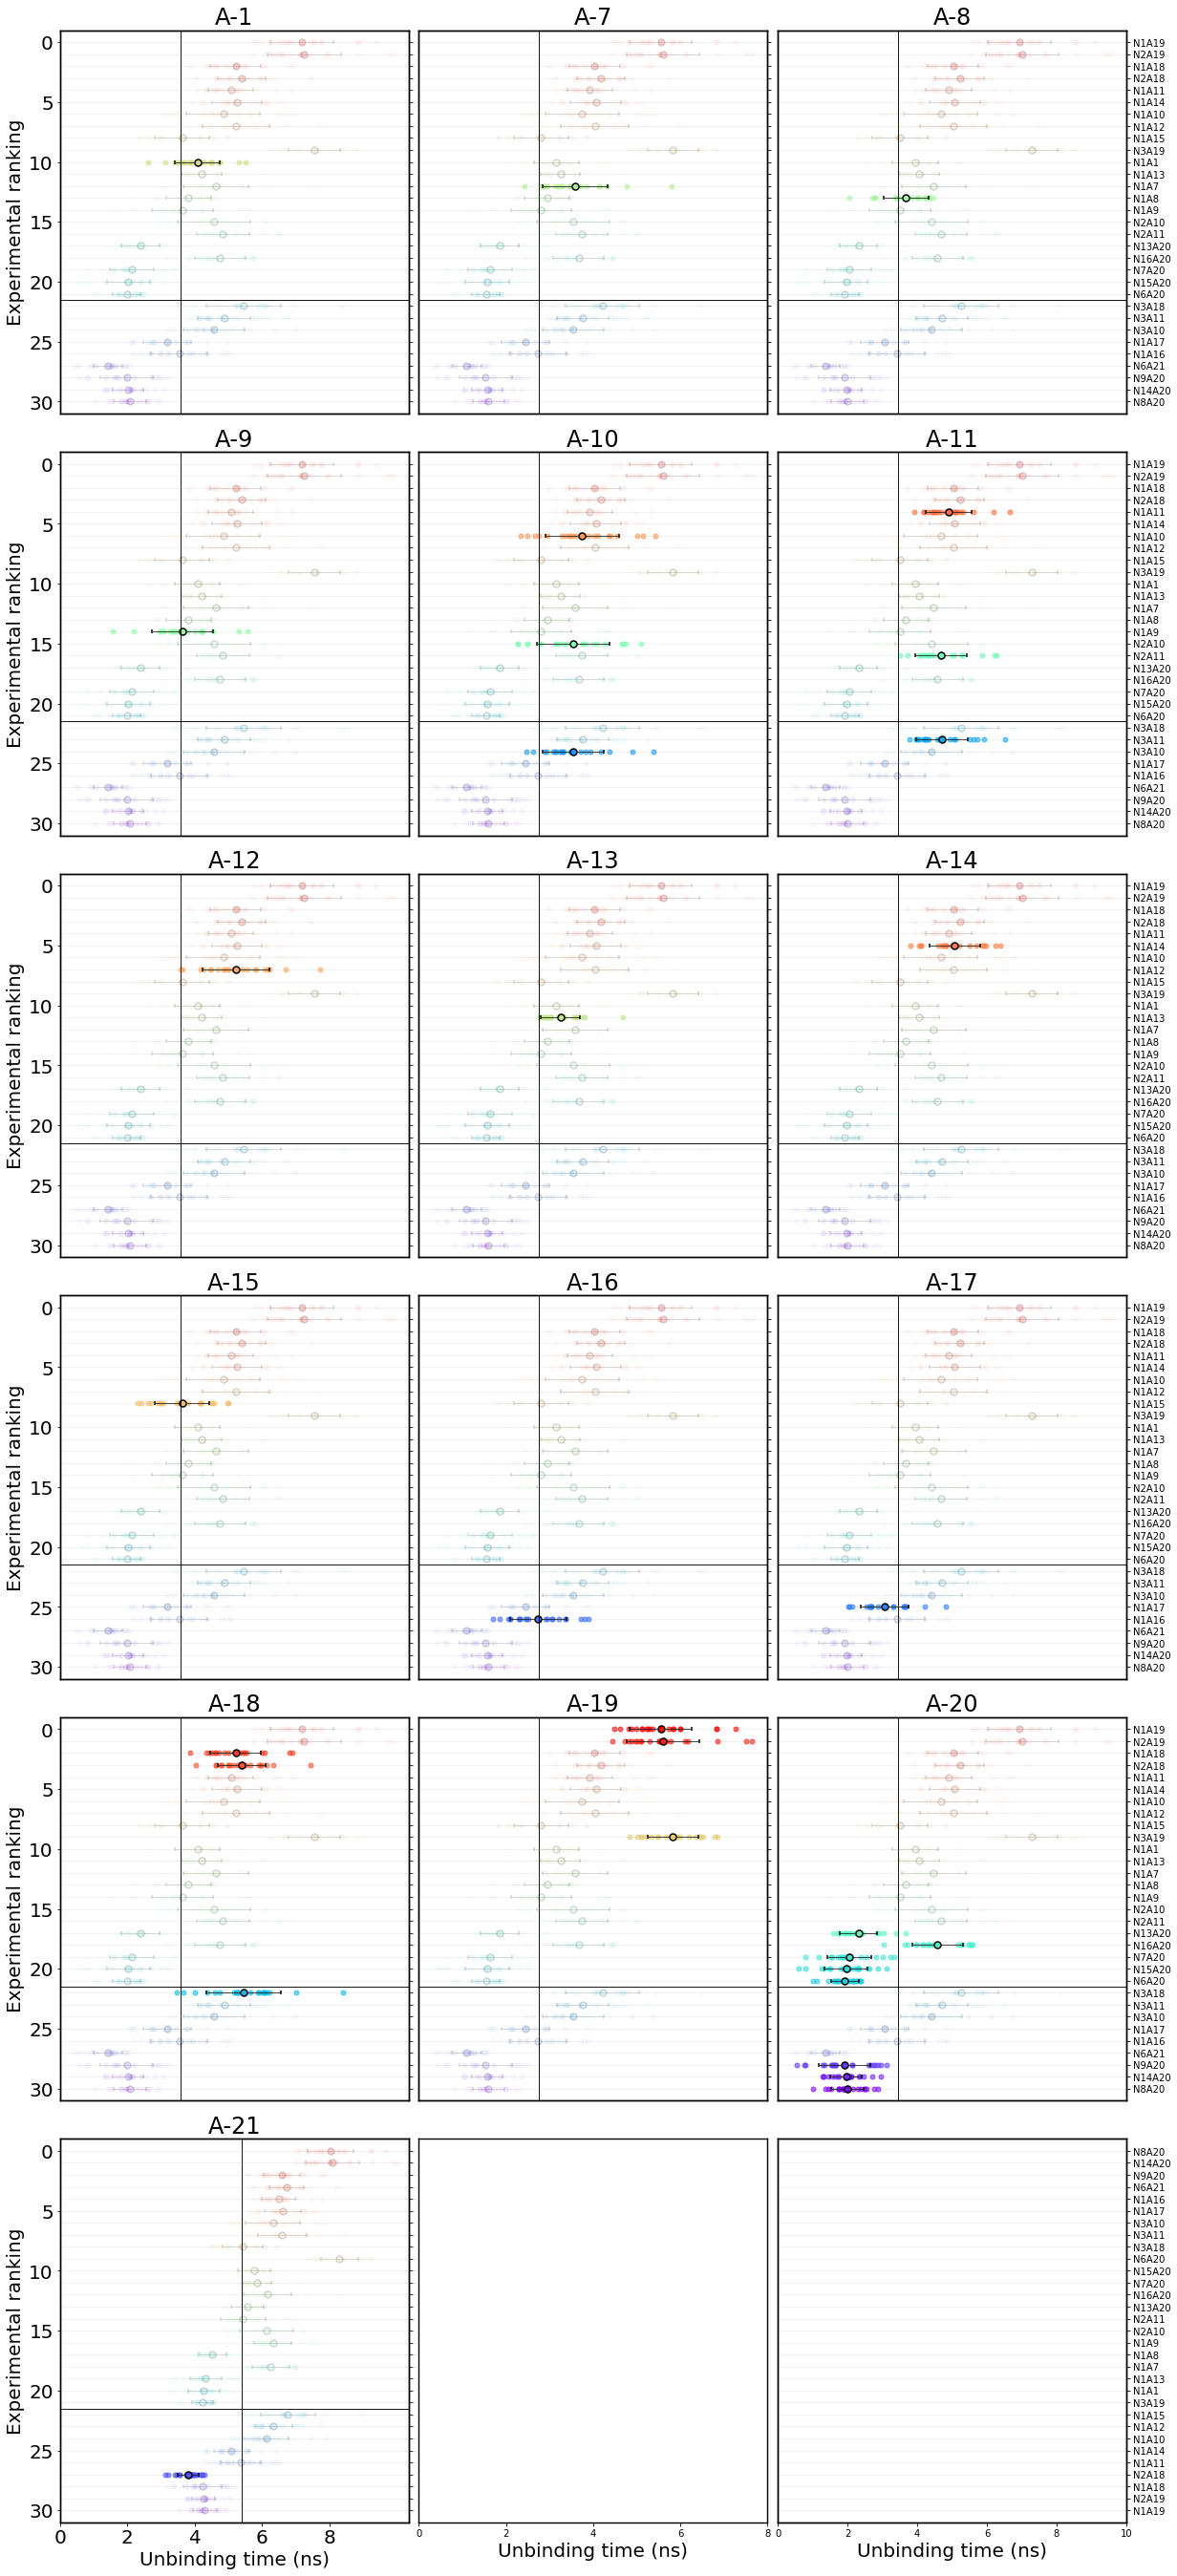

In [29]:
fig, axs = plt.subplots(figsize=(20, 48), ncols=3, nrows=6, gridspec_kw={'hspace':0.1, 'wspace':0.03})
for a, (ax, AA) in enumerate(zip(axs.flatten(), np.unique(DATA.Analyte))):
    ax2 = ax.twinx()
    ax2.set_ylim(31,-1)
    ax2.set_yticks(DATA.Act_Rank)
    ax2.grid(alpha=0.2)
    if a%3==2:
        ax2.set_yticklabels(DATA.index)
    else:
        ax2.set_yticklabels([])
    ax.set_ylim(31,-1)
    ax.set_title("A-{}".format(AA), fontsize=Z+4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axvline(x=best_time_thres, ymin=0, ymax=1, c='k', lw=0.9, ls='-', zorder=100)
    ax.axhline(y=DATA.Act_Rank[np.where(DATA.Active==False)[0][-1]]-0.5, c='k', lw=0.9, ls='-', zorder=100)
    ax.tick_params(labelsize=Z)
    for i, (bye_time, rank, c, aa) in enumerate(zip(merged_bye_times, DATA.Act_Rank, DATA.Color, DATA.Analyte)):
        if aa == AA:
            al1 = 0.6
            al2 = 1.0
        else:
            al1 = 0.03
            al2 = 0.15
        ax.errorbar([bye_time], [rank], c=c, fmt='o', ms=5, alpha=al1)
        ax.errorbar(np.mean(bye_time), [rank], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
for ax in axs[:,0]:
    ax.set_yticks(np.linspace(0,30,7))
    ax.set_ylabel("Experimental ranking", fontsize=Z)
for a, ax in enumerate(axs[-1,:]):
    if a%3==2:
        ax.set_xticks(np.linspace(0, 10, 6))
    else:
        ax.set_xticks(np.arange(0,8.1,2))
    ax.set_xlabel("Unbinding time (ns)", fontsize=Z)
    
axs[-1,-2].set_yticks([])
axs[-1,-1].set_yticks([])
ax2 = axs[-1,-1].twinx()
ax2.set_ylim(-1,31)
ax2.set_yticks(DATA.Act_Rank)
ax2.grid(alpha=0.2)
ax2.set_yticklabels(DATA.index)
plt.savefig("Sensspec_SingleMDeta/A_dependence_rank.png", format='png', dpi=300)
plt.show()
plt.close()

# Charge/PEG

In [30]:
charged_nps = [1, 2, 3, 16]

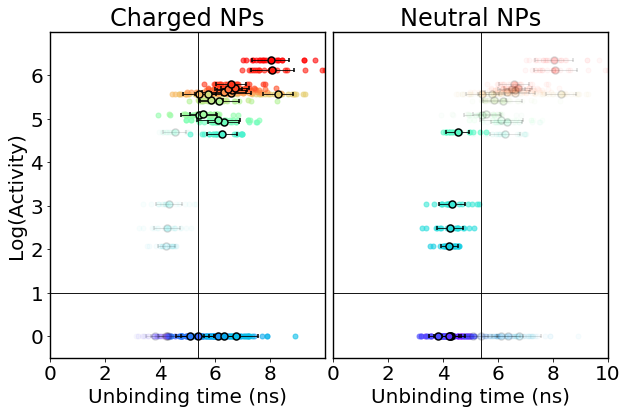

In [31]:
titles = ["Charged NPs", "Neutral NPs"]
fig, axs = plt.subplots(figsize=(10,6), ncols=2, nrows=1, gridspec_kw={'hspace':0.1, 'wspace':0.03})
for ax, title in zip(axs, titles):
    ax.set_xlabel("Unbinding time (ns)", fontsize=Z)
    ax.set_ylim(-0.5,7)
    ax.set_title(title, fontsize=Z+4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(labelsize=Z)
    ax.axhline(y=LOGACT_THRES, xmin=0, xmax=1, c='k', lw=0.9, ls='-', zorder=100)    
    ax.axvline(x=best_time_thres, ymin=0, ymax=1, c='k', lw=0.9, ls='-', zorder=100)
    ax.set_xlim(0,10)
for i, (bye_time, act_log, c, nn) in enumerate(zip(merged_bye_times, DATA.Act_log, DATA.Color, DATA.Nanoparticle)):
    if nn in charged_nps:
        al1 = 0.6
        al2 = 1.0
    else:
        al1 = 0.03
        al2 = 0.15
    axs[0].errorbar([bye_time], [act_log], c=c, fmt='o', ms=5, alpha=al1)
    axs[0].errorbar(np.mean(bye_time), [act_log], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
for i, (bye_time, act_log, c, nn) in enumerate(zip(merged_bye_times, DATA.Act_log, DATA.Color, DATA.Nanoparticle)):
    if nn not in charged_nps:
        al1 = 0.6
        al2 = 1.0
    else:
        al1 = 0.03
        al2 = 0.15
    axs[1].errorbar([bye_time], [act_log], c=c, fmt='o', ms=5, alpha=al1)
    axs[1].errorbar(np.mean(bye_time), [act_log], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
axs[0].set_xticks(np.arange(0,8.1,2))
axs[0].set_yticks(np.linspace(0,6,7))
axs[0].set_ylabel("Log(Activity)", fontsize=Z)
axs[1].set_xticks(np.linspace(0,10,6))
plt.savefig("Sensspec_SingleMDeta/NPCharge_dependence.png", format='png', dpi=300)
plt.show()
plt.close()

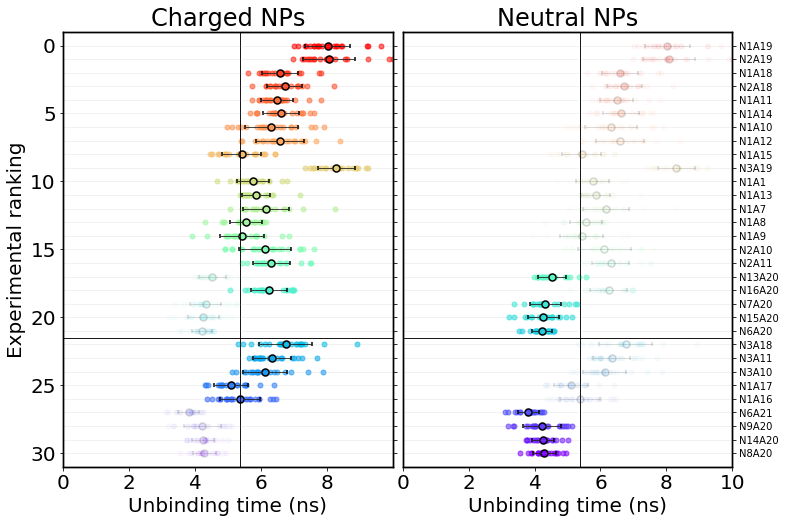

In [32]:
titles = ["Charged NPs", "Neutral NPs"]
fig, axs = plt.subplots(figsize=(12,8), ncols=2, nrows=1, gridspec_kw={'hspace':0.1, 'wspace':0.03})
for ax, title in zip(axs, titles):
    ax2 = ax.twinx()
    ax2.set_ylim(31,-1)
    ax2.set_yticks(DATA.Act_Rank)
    ax2.set_yticklabels([])
    ax2.grid(alpha=0.2)
    
    ax.set_xlabel("Unbinding time (ns)", fontsize=Z)
    ax.set_ylim(31,-1)
    ax.set_title(title, fontsize=Z+4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(labelsize=Z)
    ax.axvline(x=best_time_thres, ymin=0, ymax=1, c='k', lw=0.9, ls='-', zorder=100)
    ax.axhline(y=DATA.Act_Rank[np.where(DATA.Active==False)[0][-1]]-0.5, c='k', lw=0.9, ls='-', zorder=100)
    ax.set_xlim(0,10)
ax2.set_yticklabels(DATA.index)
for i, (bye_time, rank, c, nn) in enumerate(zip(merged_bye_times, DATA.Act_Rank, DATA.Color, DATA.Nanoparticle)):
    if nn in charged_nps:
        al1 = 0.6
        al2 = 1.0
    else:
        al1 = 0.03
        al2 = 0.15
    axs[0].errorbar([bye_time], [rank], c=c, fmt='o', ms=5, alpha=al1)
    axs[0].errorbar(np.mean(bye_time), [rank], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
for i, (bye_time, rank, c, nn) in enumerate(zip(merged_bye_times, DATA.Act_Rank, DATA.Color, DATA.Nanoparticle)):
    if nn not in charged_nps:
        al1 = 0.6
        al2 = 1.0
    else:
        al1 = 0.03
        al2 = 0.15
    axs[1].errorbar([bye_time], [rank], c=c, fmt='o', ms=5, alpha=al1)
    axs[1].errorbar(np.mean(bye_time), [rank], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
axs[0].set_xticks(np.arange(0,8.1,2))
axs[0].set_yticks(np.linspace(0,30,7))
axs[0].set_ylabel("Experimental ranking", fontsize=Z)
axs[1].set_xticks(np.linspace(0,10,6))
plt.savefig("Sensspec_SingleMDeta/NPCharge_dependence_rank.png", format='png', dpi=300)
plt.show()
plt.close()

In [33]:
anionic_a = [17, 20, 21]
cationic_a = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,19]

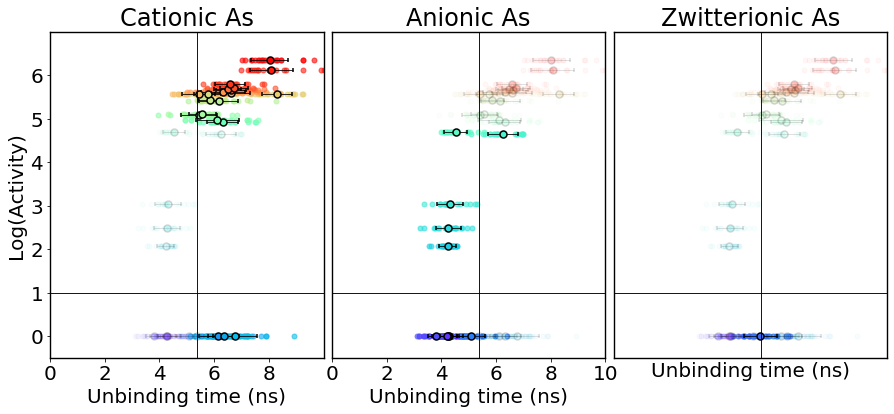

In [34]:
titles = ["Cationic As", "Anionic As", "Zwitterionic As"]
fig, axs = plt.subplots(figsize=(15,6), ncols=3, nrows=1, gridspec_kw={'hspace':0.1, 'wspace':0.03})
for ax, title in zip(axs, titles):
    ax.set_xlabel("Unbinding time (ns)", fontsize=Z)
    ax.set_ylim(-0.5,7)
    ax.set_title(title, fontsize=Z+4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(labelsize=Z)
    ax.axhline(y=LOGACT_THRES, xmin=0, xmax=1, c='k', lw=0.9, ls='-', zorder=100)    
    ax.axvline(x=best_time_thres, ymin=0, ymax=1, c='k', lw=0.9, ls='-', zorder=100)
    ax.set_xlim(0,10)
for i, (bye_time, act_log, c, aa) in enumerate(zip(merged_bye_times, DATA.Act_log, DATA.Color, DATA.Analyte)):
    if aa in cationic_a:
        al1 = 0.6
        al2 = 1.0
    else:
        al1 = 0.03
        al2 = 0.15
    axs[0].errorbar([bye_time], [act_log], c=c, fmt='o', ms=5, alpha=al1)
    axs[0].errorbar(np.mean(bye_time), [act_log], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
for i, (bye_time, act_log, c, aa) in enumerate(zip(merged_bye_times, DATA.Act_log, DATA.Color, DATA.Analyte)):
    if aa in anionic_a:
        al1 = 0.6
        al2 = 1.0
    else:
        al1 = 0.03
        al2 = 0.15
    axs[1].errorbar([bye_time], [act_log], c=c, fmt='o', ms=5, alpha=al1)
    axs[1].errorbar(np.mean(bye_time), [act_log], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
for i, (bye_time, act_log, c, aa) in enumerate(zip(merged_bye_times, DATA.Act_log, DATA.Color, DATA.Analyte)):
    if aa not in cationic_a and aa not in anionic_a:
        al1 = 0.6
        al2 = 1.0
    else:
        al1 = 0.03
        al2 = 0.15
    axs[2].errorbar([bye_time], [act_log], c=c, fmt='o', ms=5, alpha=al1)
    axs[2].errorbar(np.mean(bye_time), [act_log], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
axs[0].set_xticks(np.arange(0,8.1,2))
axs[0].set_yticks(np.linspace(0,6,7))
axs[0].set_ylabel("Log(Activity)", fontsize=Z)
axs[1].set_xticks(np.linspace(0,10,6))
plt.savefig("Sensspec_SingleMDeta/ACharge_dependence.png", format='png', dpi=300)
plt.show()
plt.close()

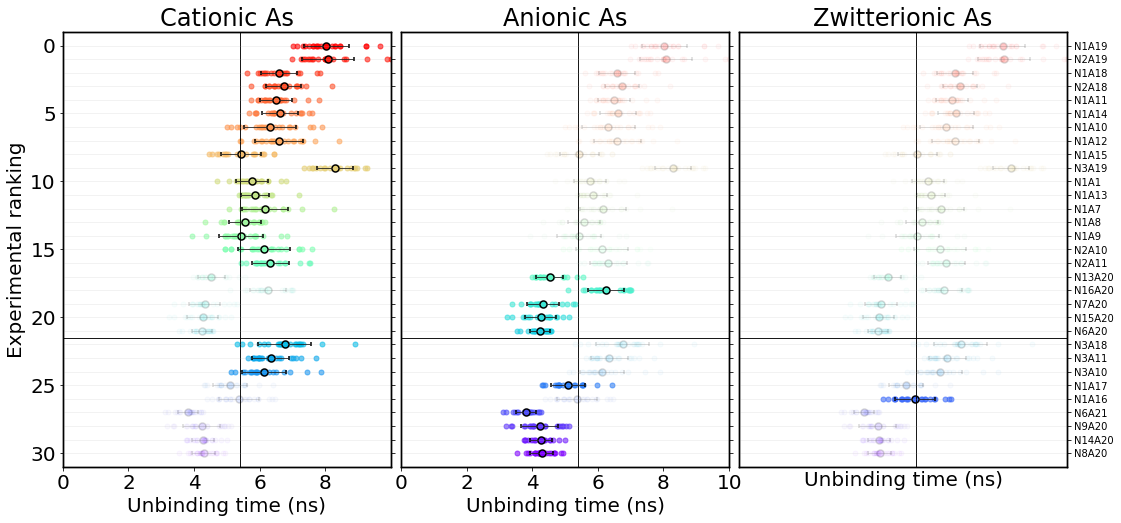

In [35]:
titles = ["Cationic As", "Anionic As", "Zwitterionic As"]
fig, axs = plt.subplots(figsize=(18,8), ncols=3, nrows=1, gridspec_kw={'hspace':0.1, 'wspace':0.03})
for ax, title in zip(axs, titles):
    ax2 = ax.twinx()
    ax2.set_ylim(31,-1)
    ax2.set_yticks(DATA.Act_Rank)
    ax2.set_yticklabels([])
    ax2.grid(alpha=0.2)
    
    ax.set_xlabel("Unbinding time (ns)", fontsize=Z)
    ax.set_ylim(31,-1)
    ax.set_title(title, fontsize=Z+4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(labelsize=Z)
    ax.axvline(x=best_time_thres, ymin=0, ymax=1, c='k', lw=0.9, ls='-', zorder=100)
    ax.axhline(y=DATA.Act_Rank[np.where(DATA.Active==False)[0][-1]]-0.5, c='k', lw=0.9, ls='-', zorder=100)
    ax.set_xlim(0,10)
ax2.set_yticklabels(DATA.index)
for i, (bye_time, rank, c, aa) in enumerate(zip(merged_bye_times, DATA.Act_Rank, DATA.Color, DATA.Analyte)):
    if aa in cationic_a:
        al1 = 0.6
        al2 = 1.0
    else:
        al1 = 0.03
        al2 = 0.15
    axs[0].errorbar([bye_time], [rank], c=c, fmt='o', ms=5, alpha=al1)
    axs[0].errorbar(np.mean(bye_time), [rank], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
for i, (bye_time, rank, c, aa) in enumerate(zip(merged_bye_times, DATA.Act_Rank, DATA.Color, DATA.Analyte)):
    if aa in anionic_a:
        al1 = 0.6
        al2 = 1.0
    else:
        al1 = 0.03
        al2 = 0.15
    axs[1].errorbar([bye_time], [rank], c=c, fmt='o', ms=5, alpha=al1)
    axs[1].errorbar(np.mean(bye_time), [rank], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
for i, (bye_time, rank, c, aa) in enumerate(zip(merged_bye_times, DATA.Act_Rank, DATA.Color, DATA.Analyte)):
    if aa not in cationic_a and aa not in anionic_a:
        al1 = 0.6
        al2 = 1.0
    else:
        al1 = 0.03
        al2 = 0.15
    axs[2].errorbar([bye_time], [rank], c=c, fmt='o', ms=5, alpha=al1)
    axs[2].errorbar(np.mean(bye_time), [rank], xerr=np.std(bye_time), c=c, fmt='o', ms=7, mec='k', mew=1.5, zorder=50, elinewidth=0.8, ecolor='k', capsize=2, alpha=al2)
axs[0].set_xticks(np.arange(0,8.1,2))
axs[0].set_yticks(np.linspace(0,30,7))
axs[0].set_ylabel("Experimental ranking", fontsize=Z)
axs[1].set_xticks(np.linspace(0,10,6))
plt.savefig("Sensspec_SingleMDeta/ACharge_dependence_rank.png", format='png', dpi=300)
plt.show()
plt.close()

# Bind/Unbind sets

In [36]:
bind_times = merged_bye_times[DATA.Active==True,:].flatten()
unbind_times = merged_bye_times[DATA.Active==False,:].flatten()
print(np.shape(bind_times))
print(np.shape(unbind_times))

(462,)
(189,)


In [37]:
ks, p_val = ks_2samp(bind_times, unbind_times)
print(ks, p_val) #pval is the probability of having the same distributions

0.34583934583934584 1.1307057063056286e-14


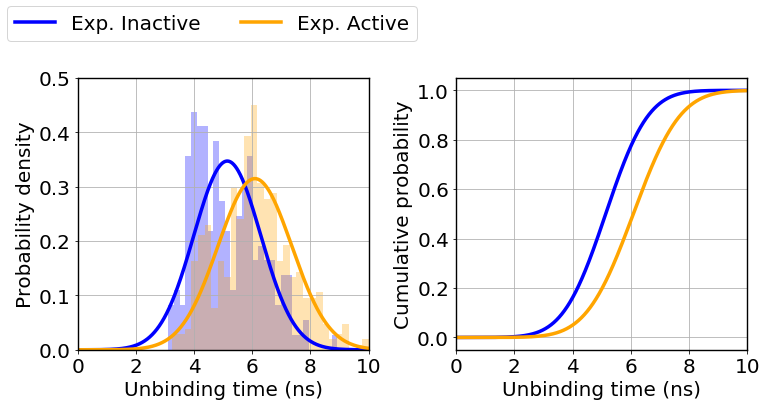

In [38]:
fig, axs = plt.subplots(figsize=(12,5), ncols=2, nrows=1, gridspec_kw={'wspace':0.3})

mu, sigma = norm.fit(unbind_times)
pdf = gaussian(times, mu, sigma)
axs[0].plot(times, pdf, color='b', lw=3.5, label="Exp. Inactive")
axs[0].hist(unbind_times, bins=30, alpha=0.3, density=True, color='b')
axs[1].plot(times, np.cumsum(pdf*(times[1]-times[0])), color='b', lw=3.5)

mu, sigma = norm.fit(bind_times)
pdf = gaussian(times, mu, sigma)
axs[0].plot(times, pdf, color='orange', lw=3.5, label="Exp. Active")
axs[0].hist(bind_times, bins=30, alpha=0.3, density=True, color='orange')
axs[1].plot(times, np.cumsum(pdf*(times[1]-times[0])), color='orange', lw=3.5)
for ax in axs:
    ax.tick_params(labelsize=Z)
    ax.set_xlabel("Unbinding time (ns)", fontsize=Z)
    ax.set_xticks(np.linspace(0, 10, 6))
    ax.set_xlim(0,10)
    ax.grid()
axs[0].set_ylabel("Probability density", fontsize=Z)
axs[0].set_ylim(0,0.5)
axs[0].legend(loc='upper right', fontsize=Z, bbox_to_anchor=(1.2,1.3), ncol=2)
#axs[1].set_ylim(0,1)
axs[1].set_ylabel("Cumulative probability", fontsize=Z)
plt.savefig("Sensspec_SingleMDeta/Distributions.png", format='png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Tree analysis

In [39]:
NP_lonepairs = {1:7, 2:9, 3:9, 5:14, 6:8, 7:8, 8:10, 9:10, 10:8, 11:8, 12:10, 13:8, 14:10, 15:8, 16:0}
NP_hydrogens = {1:0, 2:1, 3:1, 5:1, 6:1, 7:2, 6:1, 7:2, 8:1, 9:2, 10:0, 11:0, 12:2, 13:3, 14:1, 15:1, 16:3}
AN_lonepairs = {1:0, 6:0, 7:0, 8:2, 9:4, 10:2, 11:2, 12:4, 13:2, 14:5, 15:2, 16:5, 17:7, 18:0, 19:0, 20:7, 21:6}
AN_hydrogens = {1:3, 6:2, 7:4, 8:4, 9:5, 10:3, 11:3, 12:3, 13:5, 14:3, 15:3, 16:3, 17:1, 18:3, 19:3, 20:1, 21:1} #Fluors were included
NP_pcharges = {1:0, 2:0, 3:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:1}
NP_ncharges = {1:1, 2:1, 3:1, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0}
A_pcharges = {1:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1, 17:0, 18:1, 19:1, 20:0, 21:0}
A_ncharges = {1:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:1, 17:1, 18:0, 19:0, 20:1, 21:1}
NP_arrings = {1:0, 2:1, 3:1, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0}
A_arrings = {1:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:2, 14:1, 15:1, 16:1, 17:1, 18:2, 19:4, 20:1, 21:1}

np_lonepairs = [NP_lonepairs[n] for n in Ns]
np_hydrogens = [NP_hydrogens[n] for n in Ns]
a_lonepairs = [AN_lonepairs[a] for a in As]
a_hydrogens = [AN_hydrogens[a] for a in As]
np_pcharges = [NP_pcharges[n] for n in Ns]
np_ncharges = [NP_ncharges[n] for n in Ns]
a_pcharges = [A_pcharges[a] for a in As]
a_ncharges = [A_ncharges[a] for a in As]
np_arrings = [NP_arrings[n] for n in Ns]
a_arrings = [A_arrings[a] for a in As]

ml_cols = ['Unbind_time', 'Rog_Mean', 'Sasa_Mean', 'NP_lonepairs', 'NP_hydrogens', 'NP_pcharges', 'NP_ncharges', 'NP_arrings', 'A_lonepairs', 'A_hydrogens', 'A_pcharges', 'A_ncharges', 'A_arrings']
X_set = pd.DataFrame(zip(np.mean(merged_bye_times, axis=1), DATA['Rog_Mean'], DATA['Sasa_Mean'], np_lonepairs, np_hydrogens, np_pcharges, np_ncharges, np_arrings, a_lonepairs, a_hydrogens, a_pcharges, a_ncharges, a_arrings), columns=ml_cols, index=Systems)
Y_set = DATA.Active.astype(int)
ml_set = X_set.join(Y_set)

In [40]:
ml_set

,Unbind_time,Rog_Mean,Sasa_Mean,NP_lonepairs,NP_hydrogens,NP_pcharges,NP_ncharges,NP_arrings,A_lonepairs,A_hydrogens,A_pcharges,A_ncharges,A_arrings,Active
N8A20,4.291238,12.222698,11760.771084,10,1,0,0,0,7,1,0,1,1,0
N14A20,4.258476,12.293464,12253.439625,10,1,0,0,0,7,1,0,1,1,0
N9A20,4.226857,12.348903,13136.572691,10,2,0,0,0,7,1,0,1,1,0
N6A21,3.812762,11.968188,11318.383668,8,1,0,0,0,6,1,0,1,1,0
N1A16,5.366286,11.543482,11198.530120,7,0,0,1,0,5,3,1,1,1,0
N1A17,5.095810,11.597224,11335.532530,7,0,0,1,0,7,1,0,1,1,0
N3A10,6.122476,12.581886,12956.388621,9,1,0,1,1,2,3,1,0,1,0
N3A11,6.341143,12.579910,13177.691299,9,1,0,1,1,2,3,1,0,1,0
N3A18,6.760952,12.559191,13147.861178,9,1,0,1,1,0,3,1,0,2,0
N6A20,4.229524,12.015950,11625.866667,8,1,0,0,0,7,1,0,1,1,1


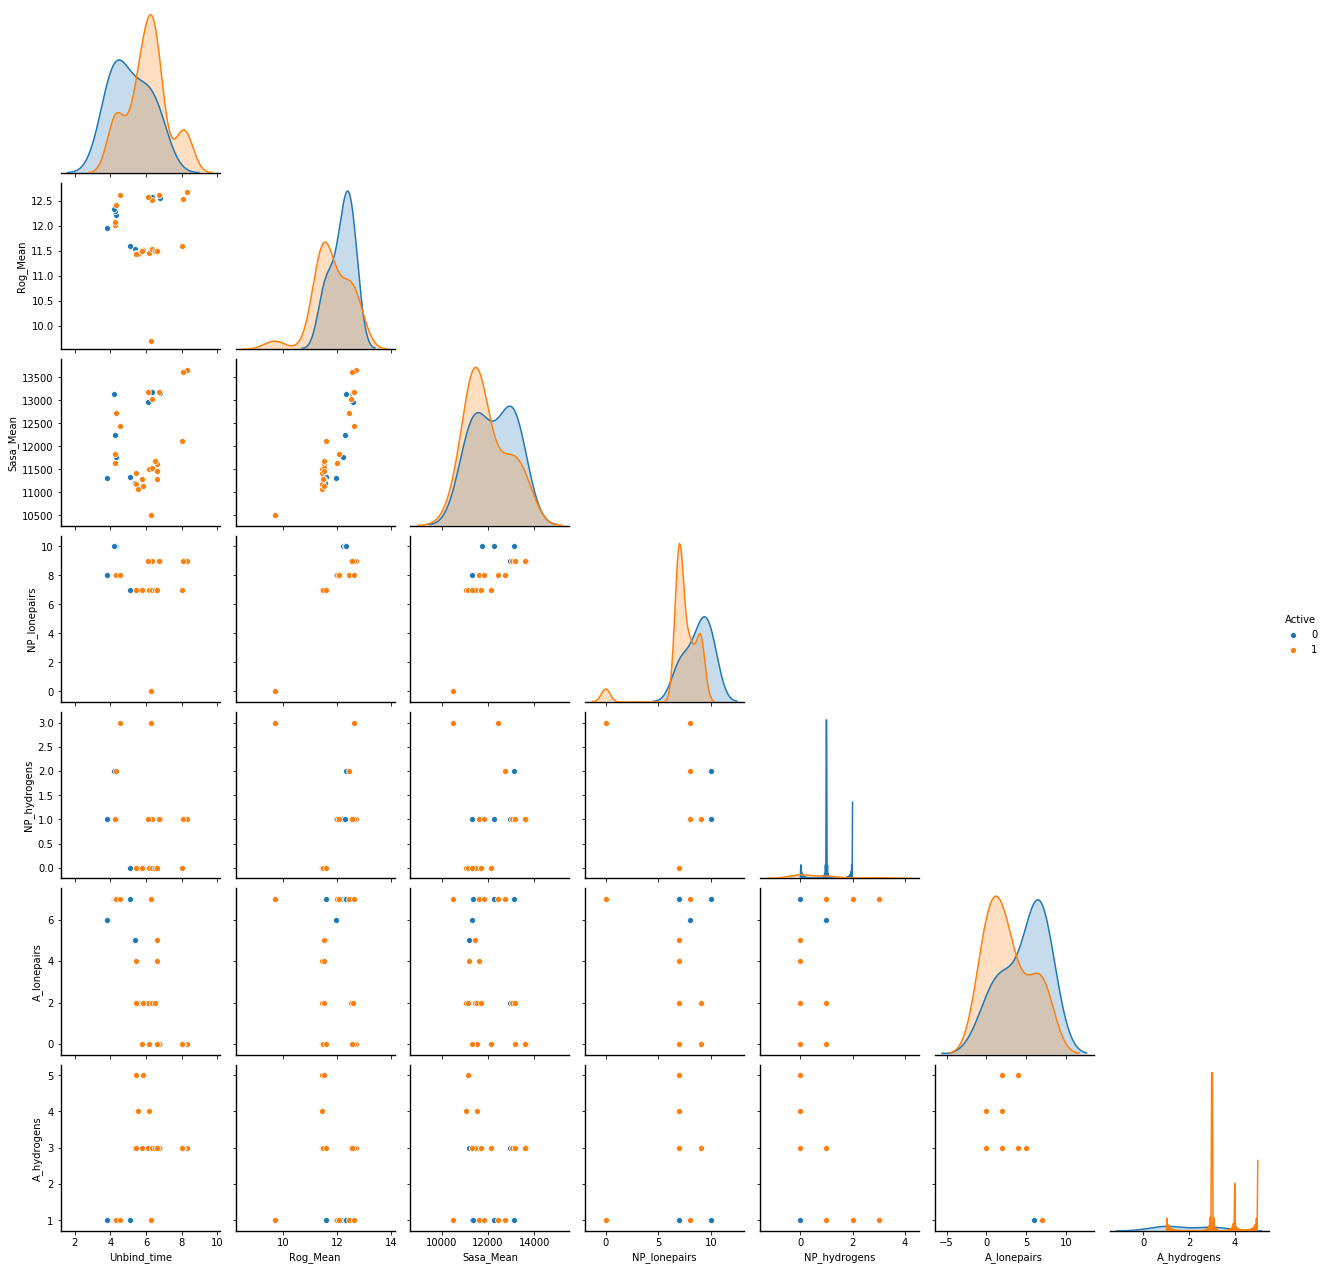

In [41]:
g = sns.pairplot(ml_set, hue='Active', x_vars=['Unbind_time', 'Rog_Mean', 'Sasa_Mean', 'NP_lonepairs', 'NP_hydrogens', 'A_lonepairs', 'A_hydrogens'], y_vars=['Unbind_time', 'Rog_Mean', 'Sasa_Mean', 'NP_lonepairs', 'NP_hydrogens', 'A_lonepairs', 'A_hydrogens'], corner=True)

In [42]:
def accuracy(confusion):
    return np.sum(np.diagonal(confusion))/np.sum(confusion)

def sensitivity(confusion):
    return confusion[1,1]/(confusion[1,1]+confusion[1,0])

def specificity(confusion):
    return confusion[0,0]/(confusion[0,0]+confusion[0,1])

In [43]:
MAX_DEPTH=2
metric = 0
for i in range(1000):
    dt = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=i, splitter='random')
    dt.fit(X_set, Y_set)
    Y_pred = dt.predict(X_set)
    confusion = confusion_matrix(Y_set, Y_pred)
    current_metric = accuracy(confusion)  #Quality metric
    if current_metric > metric:
        best_state = i*1
        metric = current_metric*1
dt = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=best_state, splitter='random')
dt.fit(X_set, Y_set)
Y_pred = dt.predict(X_set)
confusion = confusion_matrix(Y_set, Y_pred)
print("Accuracy: {:.2f}".format(accuracy(confusion)))
print("Sensitivity: {:.2f}".format(sensitivity(confusion)))
print("Specificity: {:.2f}".format(specificity(confusion)))

Accuracy: 0.84
Sensitivity: 0.91
Specificity: 0.67


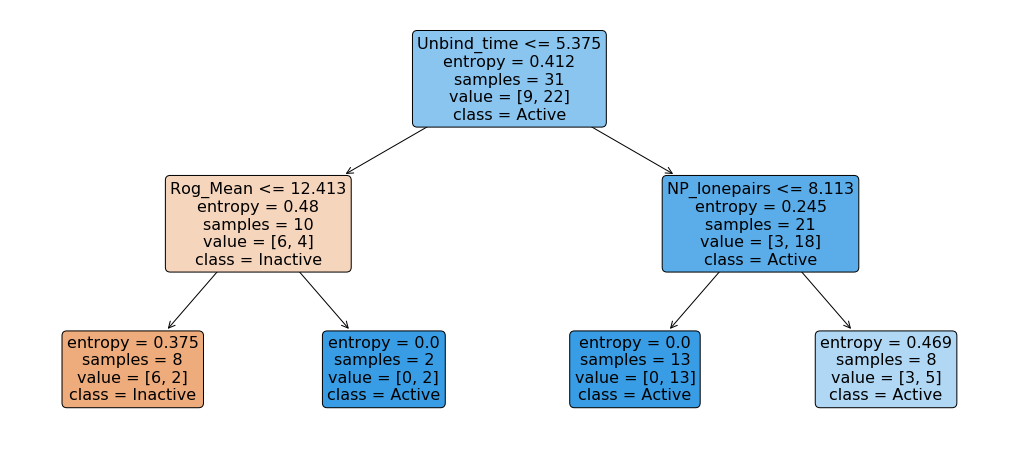

In [44]:
fig = plt.figure(figsize=(18,8))
ax = plt.axes()
plot_tree(dt, ax=ax, filled=True, feature_names=ml_cols, class_names=['Inactive', 'Active'], rounded=True, rotate=True, fontsize=Z-4)
plt.show()
plt.close()